*Aprenentatge Computacional*

**Autor:**
- Sebastian Malbaceda Leyva (1681519)

**Github**:
https://github.com/NIU1681519/CasKaggleStudentAlcoholConsumption


# Cas Kaggle - Student Alcohol Consumption

En aquesta pràctica s'abordarà la creació d'un model d'aprenentatge computacional enfocat en classificació. Aquest model s'encarregarà de predir el nivell de consum d'alcohol dels estudiants als caps de setmana. Per poder aconseguir això, s'ha pogut recollir una sèrie de dades d'un institut. Aquestes dades són una sèrie de característiques de cada estudiant on es pot trobar informació tant relacionada amb l'ambient on es troba com amb el rendiment acadèmic que ha demostrat.

Per poder obtenir el millor model possible, seguirem una sèrie de passos on analitzarem les dades obtingudes, les processarem, triarem una sèrie de models candidats per entrenar i analitzarem els resultats obtinguts, decidint el millor classificador.

Motius per fer un analisi d'aquest estil:

Mesurar el consum d'alcohol dels estudiants els caps de setmana podria ser útil per a universitats, serveis de salut mental i polítiques públiques. Aquesta anàlisi permetria identificar patrons de comportament de risc i ajudar en el desenvolupament de programes preventius per afavorir hàbits més saludables. A més, permetria realitzar intervencions personalitzades per aquells estudiants amb patrons de consum perjudicials per a la seva salut. En resum, aquestes dades podrien millorar el benestar estudiantil i ajudar a crear un ambient més saludable i equilibrat.

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades.

In [902]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score,  precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from scipy.stats import chi2_contingency

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import cross_val_score, learning_curve, cross_val_predict, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

### 1. EDA (exploratory data analysis)

Previ a observar el dataset, hem de carregar tot el necessari per poder començar a treballar.

A la pàgina del cas Kaggle es pot trobar informació dels datasets que es carreguen. El que faré és utilitzar els dos datasets que pertanyen a dos grups d'alumnes d'un cert institut. Un d'ells és el de la classe de matemàtiques i l'altre és el dels alumnes de portuguès.

Per a l'anàlisi de dades, el que es farà serà utilitzar els dos datasets de manera concatenada, és a dir, juntarem tots dos datasets per poder tenir un model més estable. Segons certes aclaracions a la pàgina de Kaggle, hi ha alumnes que poden pertànyer a les dues classes, així que s'aconsella tractar de filtrar aquests alumnes. Es menciona breument que aquells alumnes amb atributs idèntics són els que pertanyen a totes dues classes. Potser no és del tot clar, però considerarem que si un registre és exactament idèntic a un altre, serà eliminat, quedant-nos només amb un d'ells. Per tant, el que farem serà concatenar els datasets i eliminar els duplicats.

In [903]:
dataset_math = pd.read_csv("data/student-mat.csv")
dataset_por = pd.read_csv("data/student-por.csv")

dataset = pd.concat([dataset_math, dataset_por], ignore_index=True)
dataset = dataset.drop_duplicates()

A continuació es farà la partició del dataset resultant considerant la característica objectiu a predir. En aquest cas, com es suggereix al títol, ens centrarem a predir el nivell d'alcohol, de manera que analitzarem aquelles característiques que influeixen en aquest.

Hi ha dues característiques principals que fan referència al consum, com per exemple Walc (consum d'alcohol els caps de setmana) i, per altra banda, Dalc, que fa referència al nivell de consum d'alcohol els dies laborals.

En aquesta pràctica ens centrarem a predir el Walc, ja que és més probable que tingui un impacte més gran en estudiants joves. Descartem Dalc perquè potser no tots els estudiants treballen des de joves o no té massa pes si ens referim als dies hàbils.

Veurem graficament el dataset abants de fer la particio en test i train

Recompte de cada classe:
Walc
1    398
2    235
3    200
4    138
5     73


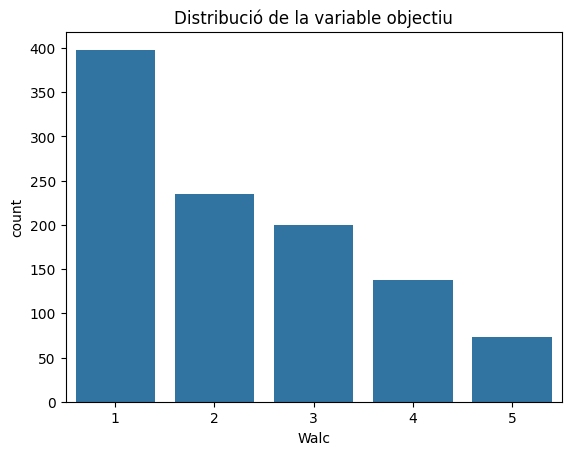

In [904]:
class_counts = dataset['Walc'].value_counts()
print("Recompte de cada classe:")
print(class_counts.to_string())

sns.countplot(x='Walc', data=dataset)
plt.title('Distribució de la variable objectiu')
plt.show()

Vist la proporció dels 5 nivells de consum, observem clarament un desbalanç considerable i una forta tendència a haver-hi més alumnes que consumeixen poc alcohol (Walc = 1). El nivell 1 indica baix consum, mentre que el nivell 5 indica consum alt.

En tenir molt poques mostres d'alumnes que consumeixen molt alcohol, prendrem la decisió de destinar un 80% de les dades al train i un 20% a la part de test, a més a més de que es farà una partició equilibrada i es consideraràn tècniques i estratègies de balanceig.

In [905]:
train, test = train_test_split(dataset, train_size=0.8, stratify=dataset['Walc'], random_state=42)

dataset.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15


Procedirem a mostrar les dimensions obtingudes tant del dataset amb el qual treballem com del train que analitzarem i del test.

In [906]:
print("El nombre de mostres que tenim a la base de dades és de",dataset.shape[0])
print("El nombre de atributs que tenim a la base de dades és de",dataset.shape[1])

print("El nombre de mostres que tenim al train és de",train.shape[0])
print("El nombre de atributs que tenim al train és de",train.shape[1])

print("El nombre de mostres que tenim al test és de",test.shape[0])
print("El nombre de atributs que tenim al test és de",test.shape[1])

El nombre de mostres que tenim a la base de dades és de 1044
El nombre de atributs que tenim a la base de dades és de 33
El nombre de mostres que tenim al train és de 835
El nombre de atributs que tenim al train és de 33
El nombre de mostres que tenim al test és de 209
El nombre de atributs que tenim al test és de 33


Tenim una mida de mostres una mica justa per part del dataset complet i d'igual manera com s'ha mencionat, el train i el test seràn proporcionals al dataset.

Comptatge de cada classe:
Walc
1    318
2    188
3    160
4    110
5     59
Comptatge de cada classe:
Walc
1    80
2    47
3    40
4    28
5    14


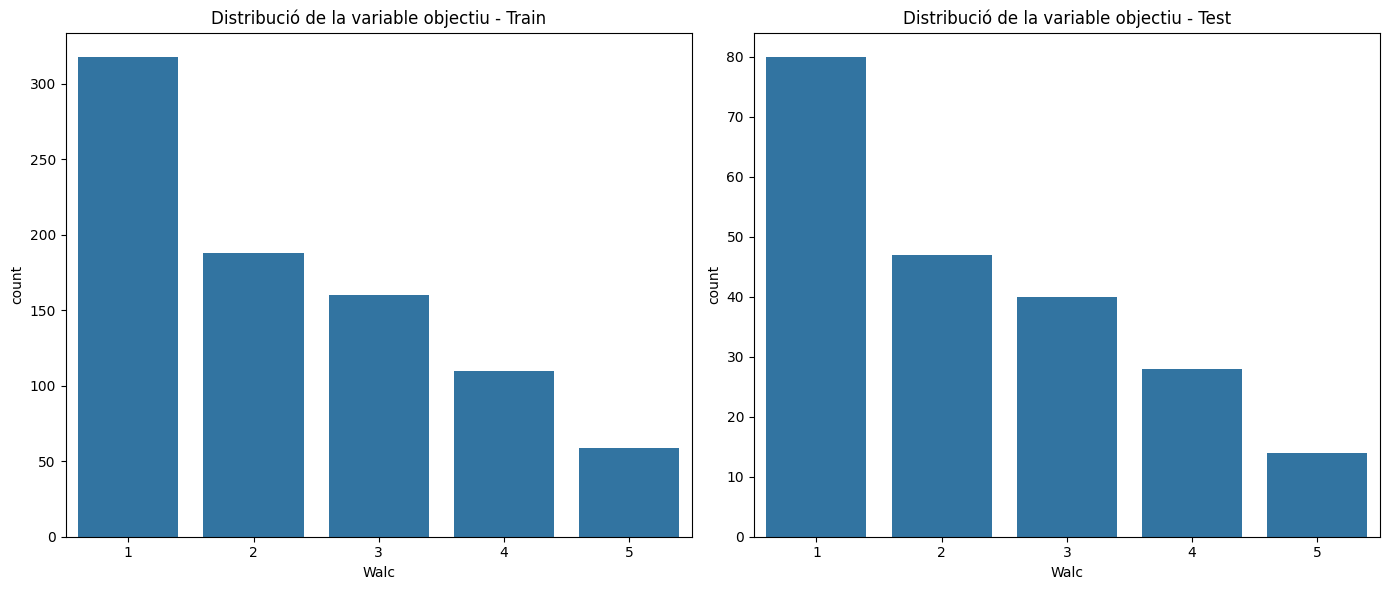

In [907]:
class_counts = train['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

class_counts = test['Walc'].value_counts()
print("Comptatge de cada classe:")
print(class_counts.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='Walc', data=train, ax=axes[0])
axes[0].set_title('Distribució de la variable objectiu - Train')

sns.countplot(x='Walc', data=test, ax=axes[1])
axes[1].set_title('Distribució de la variable objectiu - Test')

plt.tight_layout()
plt.show()

Es pot veure que disposem de 33 atributs diferents amb un total de 835 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. Com que no esta gens equilibrat, optarem per entrenar models balancellats i/o una generació sintètica de mostres si es necessari. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del cosnum.

In [908]:
print("Informació de cada atribut:")
print(dataset.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non

El dataset a treballar conté una sèrie s'atributs que pertanyen a dos grups d'estudiants de les matèries de anglés i portuguès:

- **school**: Fa referència a l'escola on estudia l'estudiant. És una variable binària que pot tenir dos valors possibles: 'GP' per Gabriel Pereira o 'MS' per Mousinho da Silveira, que són els noms de dues escoles diferents.

- **sex**: Indica el sexe de l'estudiant. És una variable binària on 'F' representa una dona i 'M' un home.

- **age**: És l'edat de l'estudiant, una variable numèrica que oscil·la entre els 15 i els 22 anys.

- **address**: Tipus d'adreça de la llar de l'estudiant. Aquesta variable és binària, amb 'U' per indicar que l'estudiant viu en una zona urbana i 'R' per indicar una zona rural.

- **famsize**: Fa referència a la mida de la família de l'estudiant. És també una variable binària on 'LE3' indica que la família té tres membres o menys i 'GT3' significa que la família té més de tres membres.

- **Pstatus**: Indica l'estat de convivència dels pares de l'estudiant. Pot ser 'T' per pares que viuen junts o 'A' per pares separats.

- **Medu**: Aquesta variable indica el nivell educatiu de la mare de l'estudiant. És numèrica i pot prendre els següents valors: 0 per cap educació, 1 per educació primària (fins al quart grau), 2 per educació de 5è a 9è grau, 3 per educació secundària, o 4 per educació superior.

- **Fedu**: Al igual que la variable anterior, Fedu indica el nivell educatiu del pare de l'estudiant amb els mateixos valors: 0 per cap educació, 1 per educació primària, 2 per educació de 5è a 9è grau, 3 per educació secundària, i 4 per educació superior.

- **Mjob**: La professió de la mare de l'estudiant. És una variable nominal que pot ser una de les següents: 'teacher' (mestra), relacionada amb la salut (salut), 'services' (com serveis civils com la policia o administració), 'at_home' (a casa), o 'other' (altres).

- **Fjob**: Fa referència a la professió del pare de l'estudiant, amb les mateixes opcions que la variable Mjob: 'teacher', 'health', 'services', 'at_home' i 'other'.

- **reason**: Motiu pel qual l'estudiant va triar aquesta escola en particular. Pot ser un dels següents: 'home' (perquè està a prop de casa), 'reputation' (per la bona reputació de l'escola), 'course' (preferència per l'assignatura), o 'other' (altres raons).

- **guardian**: Aquesta variable indica qui és el tutor legal de l'estudiant. Pot ser 'mother' (mare), 'father' (pare), o 'other' (un altre tutor).

- **traveltime**: Temps de desplaçament entre la casa i l'escola. És una variable numèrica on el valor pot ser 1 (menys de 15 minuts), 2 (de 15 a 30 minuts), 3 (de 30 minuts a 1 hora), o 4 (més d'1 hora).

- **studytime**: Temps d'estudi setmanal de l'estudiant. És també una variable numèrica amb els següents valors: 1 (menys de 2 hores), 2 (de 2 a 5 hores), 3 (de 5 a 10 hores), o 4 (més de 10 hores).

- **failures**: Nombre de suspensos en anteriors classes. És una variable numèrica on el valor pot ser 1, 2, o 3 si el nombre de suspensos és menor que 3, i 4 si l'estudiant ha suspès 3 o més classes.

- **schoolsup**: Indica si l'estudiant rep suport educatiu extra fora de les hores lectives. És binària, amb 'sí' o 'no'.

- **famsup**: Fa referència a si l'estudiant rep suport educatiu per part de la seva família. Aquesta també és una variable binària amb les opcions 'sí' o 'no'.

- **paid**: Aquesta variable indica si l'estudiant participa en classes pagades extra relacionades amb la matèria del curs, ja sigui Matemàtiques o Portuguès. També és binària, amb 'sí' o 'no'.

- **activities**: Indica si l'estudiant participa en activitats extraescolars. És una variable binària amb 'sí' o 'no'.

- **nursery**: Fa referència si l'estudiant va assistir a una escola bressol abans de començar l'escola primària. Pot ser 'sí' o 'no'.

- **higher**: Indica si l'estudiant té la intenció de continuar els seus estudis amb educació superior. També és binària, amb 'sí' o 'no'.

- **internet**: Aquesta variable indica si l'estudiant té accés a Internet a casa seva. És binària, amb 'sí' o 'no'.

- **romantic**: Indica si l'estudiant està en una relació romàntica. És binària, amb 'sí' o 'no'.

- **famrel**: Fa referència a la qualitat de les relacions familiars de l'estudiant. Aquesta és una variable numèrica, amb una escala de 1 (molt dolent) a 5 (excel·lent).

- **freetime**: Temps lliure que l'estudiant té després de l'escola. És una variable numèrica, amb una escala de 1 (molt baix) a 5 (molt alt).

- **goout**: Indica com d'apassionat és l'estudiant de sortir amb els seus amics. Aquesta variable numèrica té una escala de 1 (molt poc) a 5 (molt sovint).

- **Dalc**: Indica el consum d'alcohol de l'estudiant en dies laborables. És una variable numèrica, amb valors entre 1 (molt baix) i 5 (molt alt).

- **Walc**: Aquesta variable fa referència al consum d'alcohol durant els caps de setmana. Igual que Dalc, és una variable numèrica amb valors entre 1 (molt baix) i 5 (molt alt). (TARGET)

- **health**: Està relacionada amb l'estat de salut actual de l'estudiant. És una variable numèrica que va de 1 (molt dolent) a 5 (molt bo).

- **absences**: Indica el nombre d'absències que l'estudiant ha tingut a l'escola. Aquesta és una variable numèrica que pot oscil·lar entre 0 i 93.


- **G1**: Qualificació obtinguda per l'estudiant en el primer període del curs. És una variable numèrica que va de 0 a 20.

- **G2**: Qualificació obtinguda per l'estudiant en el segon període del curs. Aquesta també és una variable numèrica, de 0 a 20.

- **G3**: És la qualificació final obtinguda en l'assignatura, que pot ser un valor entre 0 i 20.

Les característiques es poden clasificar en **tres** grups:

**Numeriques**: 
- 'age', 'absences', 'G1', 'G2', 'G3'

**Nominals**:
- 'school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'

**Ordinals**:
- 'famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health'

Algunes característiques tenen només dues opcions possibles (per exemple, **'school', 'sex', 'address'**, etc.), per això les hem considerat com a binàries. Si les tractéssim com a variables nominales, el model hauria de crear més columnes per a cada possible valor (segons al codificar), el que augmentaria la complexitat i el temps d'entrenament. Per tant, mantenim aquestes característiques en una sola columna, evitant així un sobreentrenament i millorant l'eficiència del model.

Per altra banda, les característiques nominals que no són binàries, com **'Mjob', 'Fjob', 'reason' o 'guardian'**, les hem separades com a categòriques nominals pures perquè cada valor pot tenir més d'una categoria, però no tenen un ordre inherent.

Les característiques ordinals, com **'Medu', 'Fedu', 'traveltime'**, etc., les hem classificat en una categoria separada perquè tenen un ordre natural, però la distància entre els valors no és necessàriament uniforme. A aquestes se les tractarà com a variables ordinals, mantenint l'ordre dels valors per millorar la capacitat del model d'interpretar-les. L'objectiu Walc és oridnal.

Finalment, les característiques numèriques com **'age', 'absences', 'G1', 'G2', 'G3'** es mantenen en la seva categoria respectiva, ja que representen quantitats contínues que el model pot processar directament sense necessitat de convertir-les en categories. 

Les característiques es classifiquen en quatre grups:

**Categorical Binary Features**:
- 'school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'


**Categorical Nominal Features**:
- 'Mjob', 'Fjob', 'reason', 'guardian'


**Categorical Ordinal Features**:
- 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health'


**Categorical Numerical Features**:
- 'age', 'absences', 'G1', 'G2', 'G3'


Ara ens toca observar si tenim presència de **Nans** al nostre dataset. Si és cert, haurem de tractar tant el train com el test, on el test haurà d'agafar informació del train en cas que es vulgui fer completament de Nans, ja sigui per mitjana, moda o algun tractament de completació especialment convenient, sempre en tot moment evitant de comentre **data leakage**.

Per identificar-lo més visualment dibuixarem una gràfica:

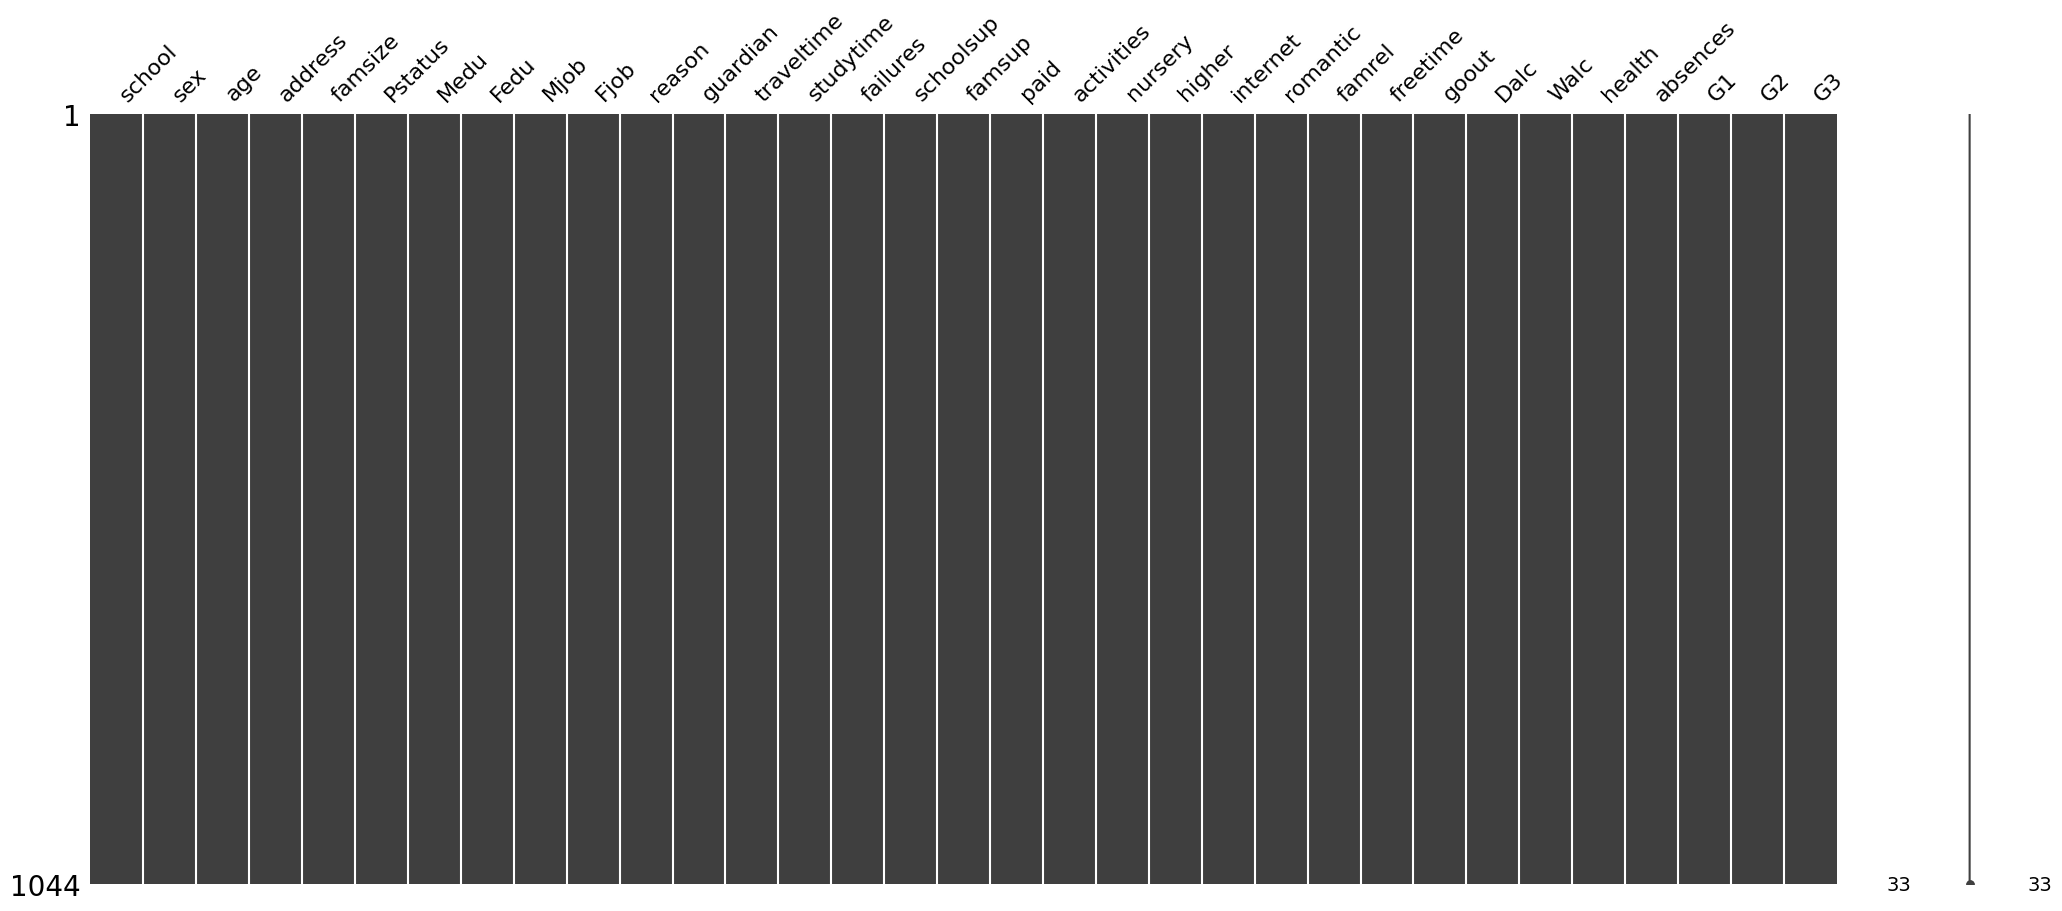

In [909]:
msno.matrix(dataset)
plt.show()

Després d'examinar el nostre dataset, podem confirmar que no hi ha valors nuls o faltants (Nans) presents en les dades. Tots els atributs del conjunt de dades estan complets, per la qual cosa no serà necessari realitzar cap tipus de tractament per gestionar aquests valors, com ara la imputació per mitjana, moda o altres tècniques de completació. Això ens permet treballar directament amb les dades disponibles sense la necessitat de dur a terme cap procés addicional de neteja o substitució de valors.

Ara es farà l'anàlisi de la relació entre els atributs d'entrada (X o features) i la variable objectiu (y o target). Per facilitar l'anàlisi, dividirem aquest estudi en dues parts:

**Atributs numèrics (numerics i ordinals)**: Explorarem com les variables numèriques es relacionen amb la variable objectiu. Utilitzarem tècniques com la correlació (coeficient de Pearson) per identificar els possibles patrons entre aquestes variables.

Es mostren característiques abans de ser codificades, desprès de la codificació es tornarà a fer el mateix.

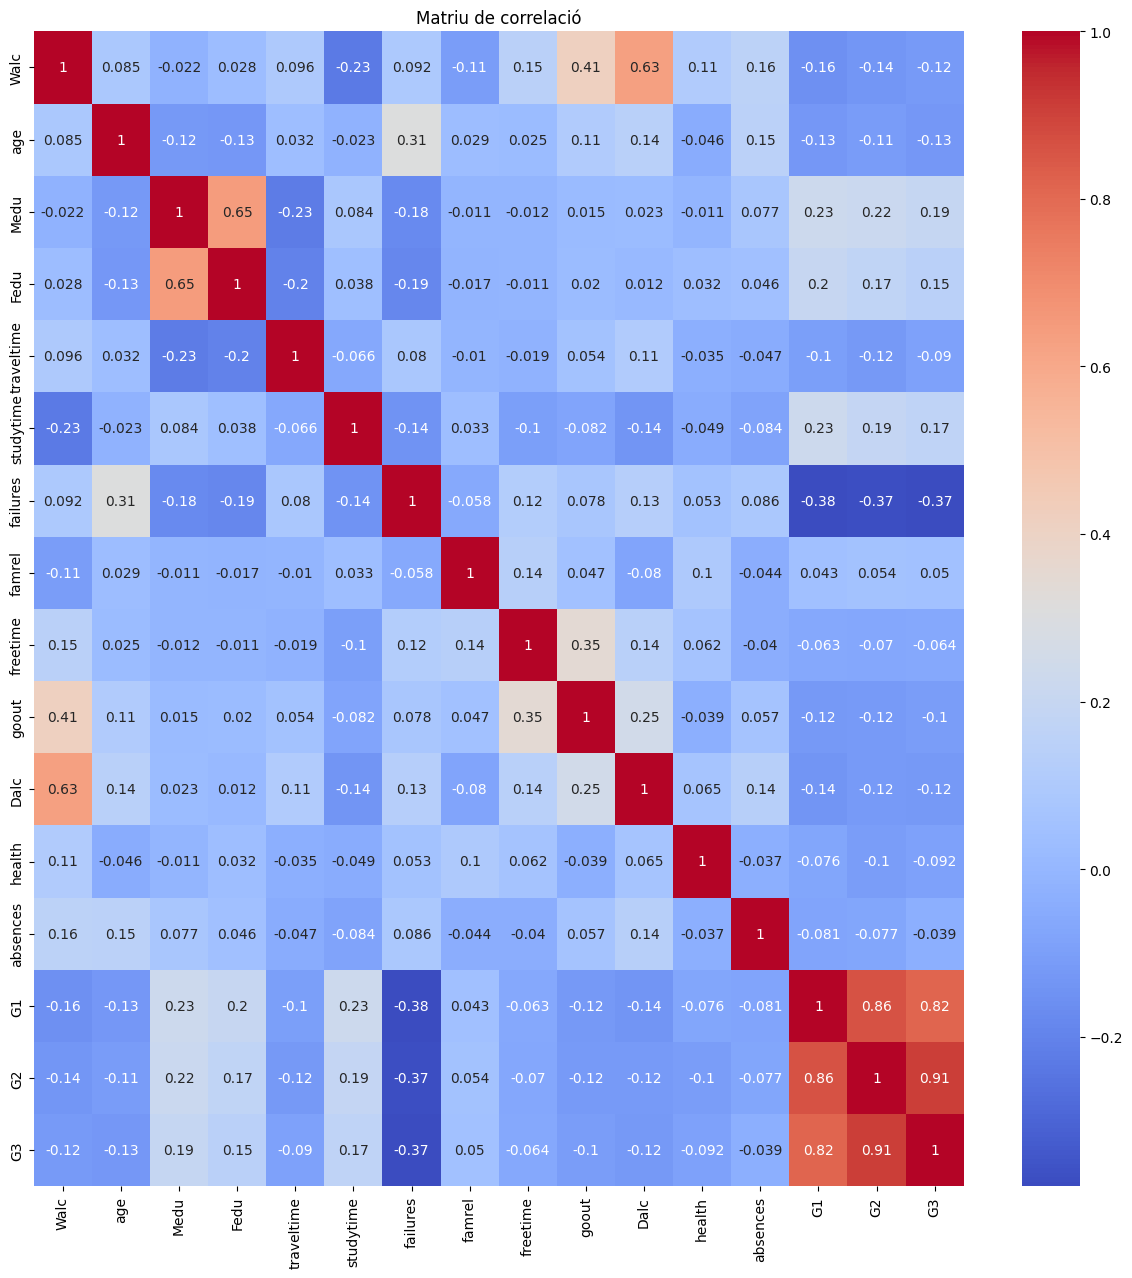

In [910]:
nume_features = ['Walc', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'health', 'absences', 'G1', 'G2', 'G3']
corr_matrix = train[nume_features].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriu de correlació')
plt.show()

A continuació es descriuen les diferents correlacions entre els atributs numèrics i el target (consum d'alcohol durant el cap de setmana, Walc):

- **Dalc i Walc (0.63)**: La forta correlació positiva entre el consum d'alcohol durant els dies laborables (Dalc) i el consum durant el cap de setmana (Walc) indica que els estudiants que consumeixen alcohol durant la setmana també tendeixen a fer-ho durant els caps de setmana. Això suggereix patrons de consum més constants i un possible risc de consum habitual.

- **goout i Walc (0.41)**: Existeix una correlació positiva moderada entre la freqüència de sortides amb amics i el consum d'alcohol durant el cap de setmana. Aquest resultat és esperable, ja que sortir amb amics en contextos informals o festius sovint està associat amb un augment del consum d'alcohol.

- **studytime i Walc (-0.23)**: Es detecta una correlació negativa feble entre el temps d'estudi setmanal i el consum d'alcohol durant el cap de setmana. Aquesta relació, tot i que no és molt intuitiva, podria tenir sentit en el context de que els estudiants que consumeixen alcohol amb més freqüència els caps de setmana podrien dedicar menys temps a l'estudi, ja que poden prioritzar les activitats socials per sobre de les acadèmiques.

- **absences i Walc (0.16)**: La correlació positiva feble entre les absències escolars i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants que consumixen alcohol en excés també tenen més probabilitats de faltar a classe, especialment després de caps de setmana amb molta festa.

- **G1, G2, G3 i Walc (-0.12, -0.13, -0.16)**: La correlació negativa entre les qualificacions acadèmiques (notes G1, G2 i G3) i el consum d'alcohol durant els caps de setmana suggereix que els estudiants que consumeixen més alcohol tendeixen a obtenir pitjors resultats acadèmics. Això podria ser causat per la disminució del temps d'estudi, la fatiga o la dificultat per concentrar-se a causa del consum excessiu d'alcohol.

- **freetime i Walc (0.15)**: La relació positiva feble suggereix que més temps lliure podria traduir-se en més oportunitats per consumir alcohol, especialment durant els caps de setmana, quan els estudiants tenen més temps per dedicar a activitats socials.

- **health i Walc (0.11)**: La correlació positiva feble entre la salut percebuda pels estudiants i el consum d'alcohol durant el cap de setmana podria indicar que els estudiants amb millor salut podrien estar més disposats a consumir alcohol durant els seus temps lliures, ja que no perceben efectes negatius immediats sobre la seva salut. Aquesta relació pot suggerir que aquells amb millor salut se senten més capacitats per participar en activitats socials, com sortir i consumir alcohol, sense percebre un impacte significatiu en el seu benestar.

- **famrel i Walc (-0.11)**: La correlació negativa feble entre la qualitat de les relacions familiars i el consum d'alcohol durant el cap de setmana indica que els estudiants amb un entorn familiar més fort i amb més suport emocional tendeixen a consumir menys alcohol, ja que reben més acompanyament i supervisió.

- **traveltime i Walc (0.096)**: La correlació positiva bastant feble suggereix que els estudiants amb desplaçaments més llargs podrien tenir un estil de vida més independent, el que podria portar a un augment en el consum d'alcohol durant els caps de setmana. **Es decidirà posteriorment si es descarta**.

- **failures i Walc (0.092)**: Existeix una correlació positiva molt feble entre el nombre de suspensos i el consum d'alcohol durant el cap de setmana. Això pot indicar que el consum freqüent d'alcohol podria afectar negativament el rendiment acadèmic, ja sigui per la reducció del temps d'estudi o per una menor capacitat de concentració. **Es decidirà posteriorment si es descarta**.

- **age i Walc (0.085)**: Tot i que la correlació és molt feble, s'observa una relació positiva entre l'edat i el consum d'alcohol durant els caps de setmana. Aquesta relació és coherent amb la tendència dels estudiants més grans a tenir més llibertat i oportunitats per sortir i experimentar amb l'alcohol. **Es decidirà posteriorment si es descarta**.

Entre altres que no s'han considerat per la seva correlacio molt baixa, com per exemple **Medu i Fedu**. **Es decidirà posteriorment si es descarten**.

Les correlacions esmentades anteriorment són orientatives, però no afirmen de manera rotunda que la relació sigui exactament com es descriu. El coeficient de correlació és més significatiu per a característiques quantitatives, com les notes G1, G2, G3 o el nombre d'absències. El que vull dir és que, tot i que es poden presentar característiques nominals en format ordinal, aquestes poden ser malinterpretades i portar a errors en la interpretació de les correlacions.

La idea principal aquí es aclarir que, tot i que les correlacions poden ser útils, cal tenir en compte que algunes característiques, especialment les nominals o ordinals, poden ser interpretades incorrectament i donar lloc a conclusions errònies

**Atributs categòrics**: Analitzarem la relació entre les variables categòriques i la variable objectiu, utilitzant gràfics per observar com la distribució de les diferents categories influeix en la predicció. El següent gràfic mostra la taxa de consum d'alcohol al caps de setmana en funció variables categòriques: school, sex, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic.

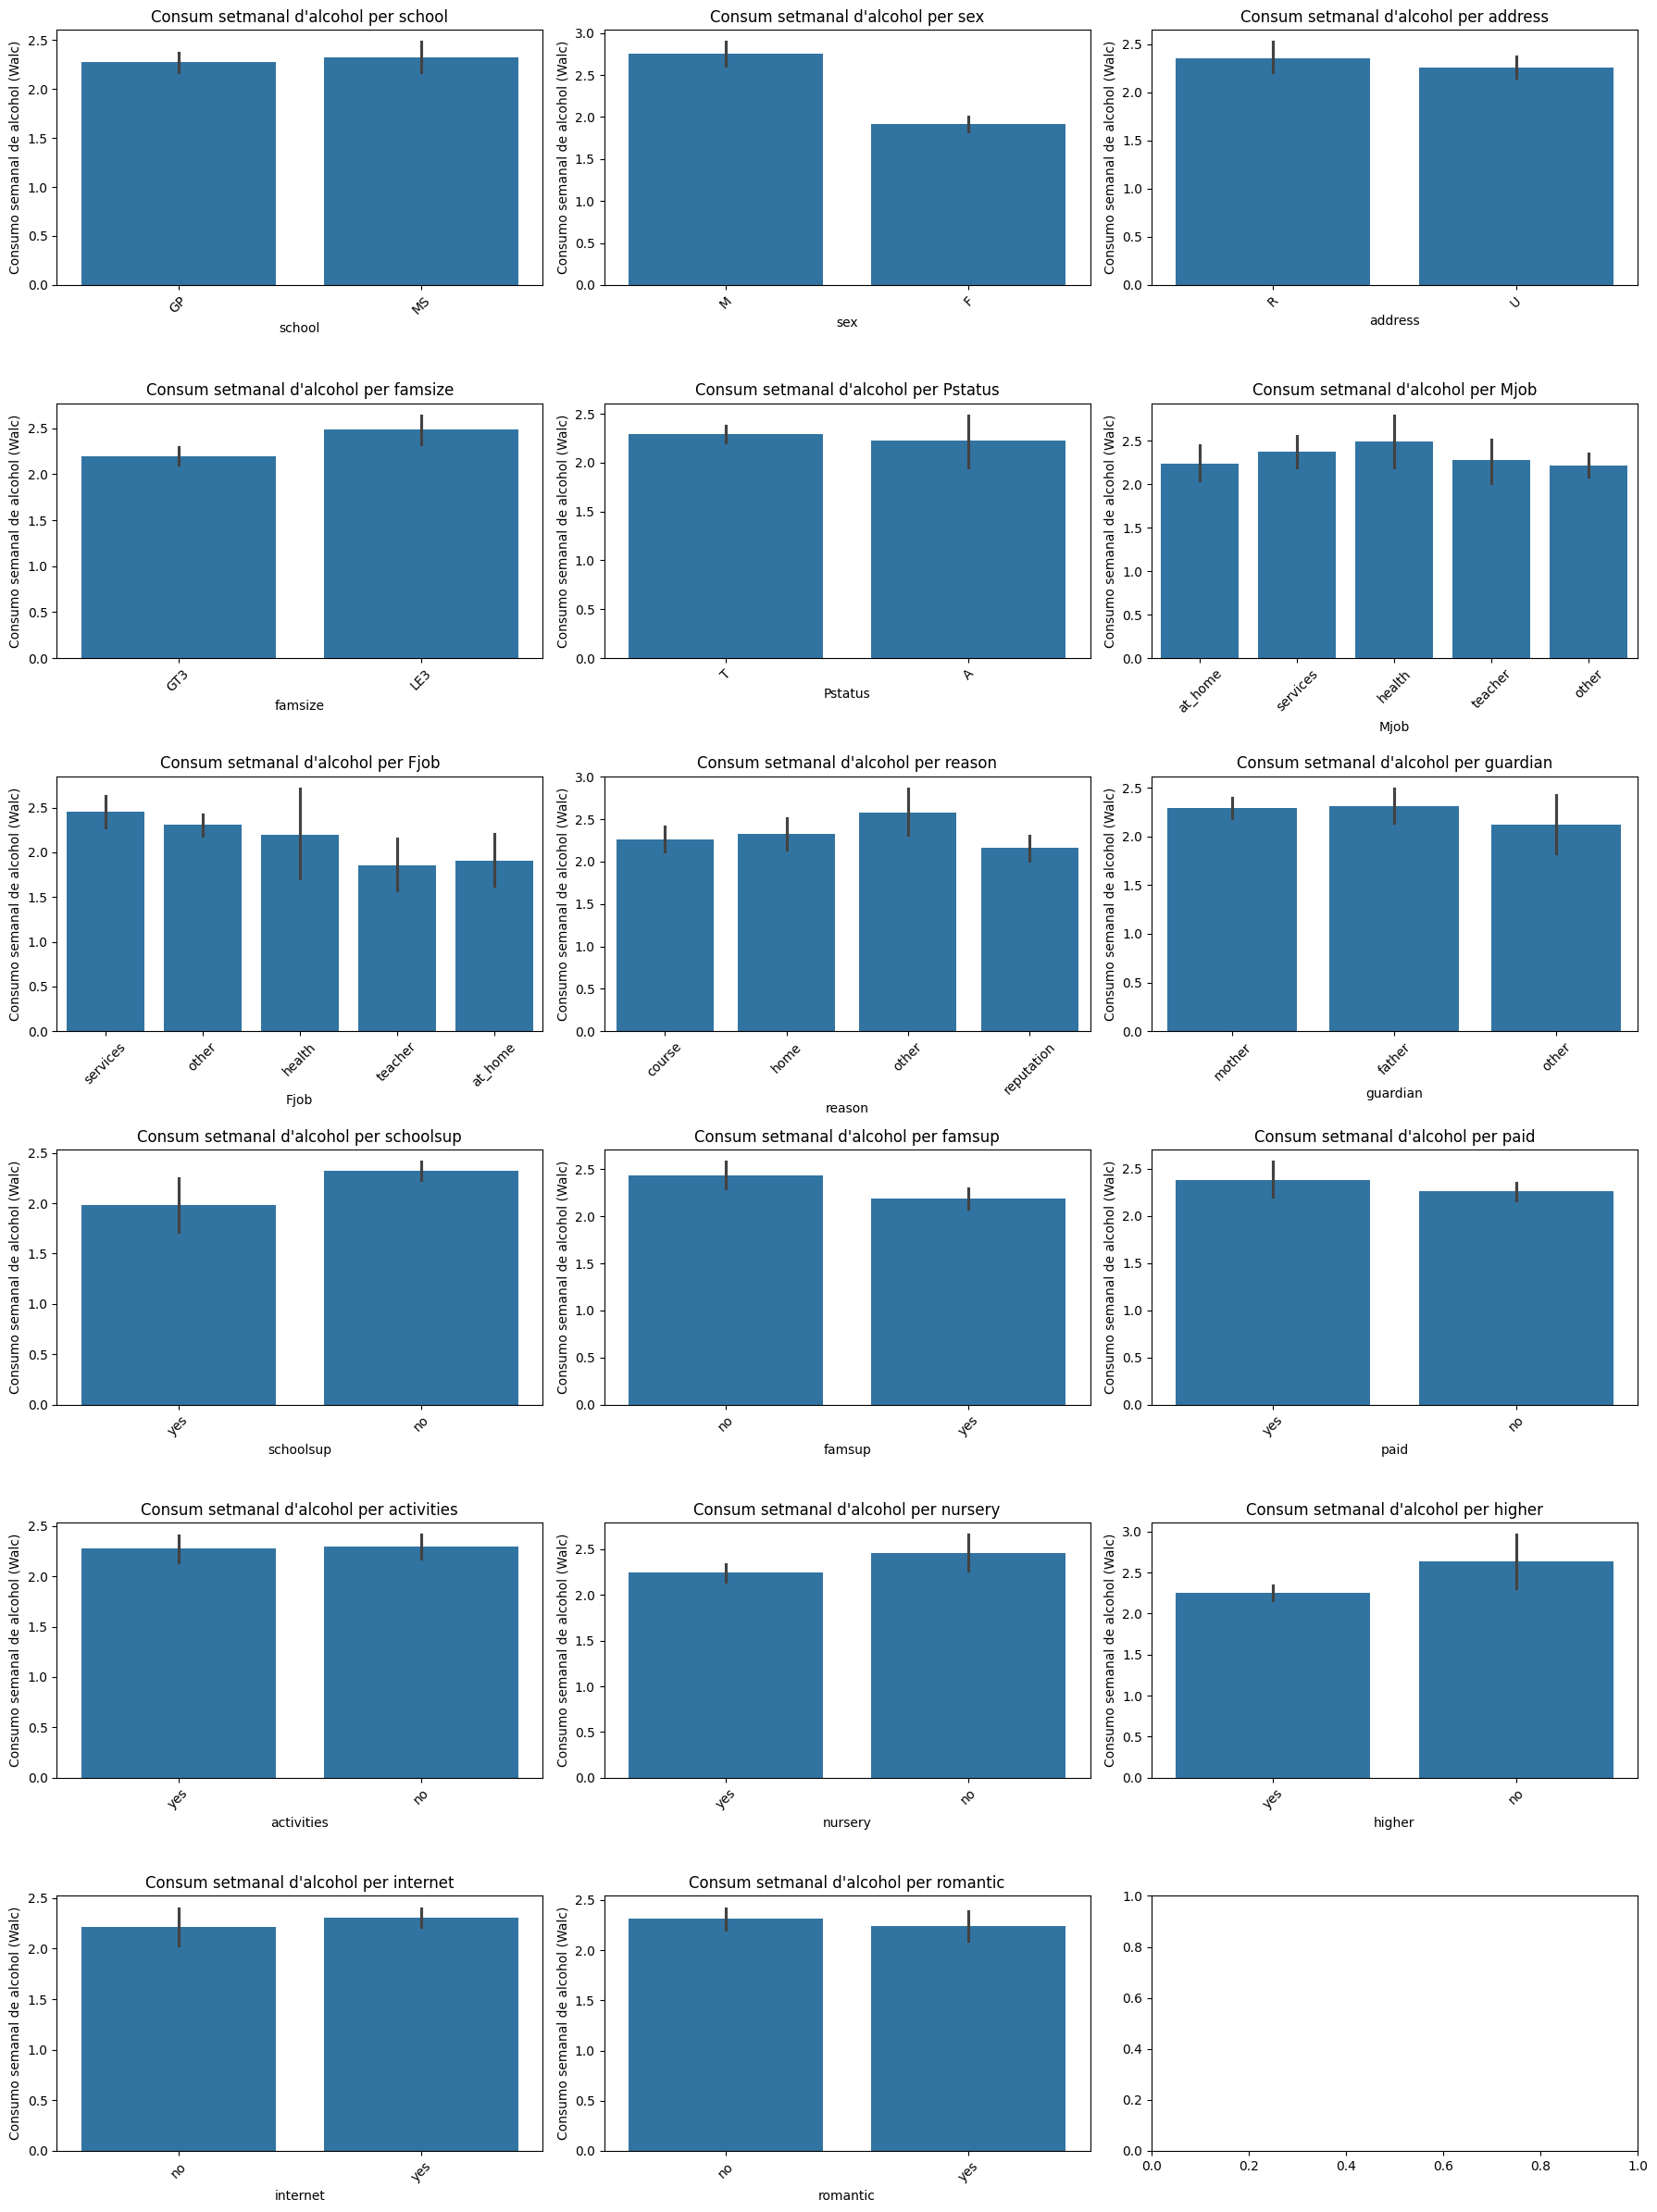

In [911]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lista de variables categóricas
categ_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
              'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
              'famsup', 'paid', 'activities', 'nursery', 'higher', 
              'internet', 'romantic']

# Crear los subgráficos
fig, axes = plt.subplots(6, 3, figsize=(18, 24))  # Ajusta el tamaño de la figura si es necesario

# Iterar a través de las variables categóricas
for idx, var in enumerate(categ_vars):
    row, col = divmod(idx, 3)  # Ubicación de cada gráfico
    # Graficar el consumo semanal de alcohol ('Walc') en función de la variable categórica
    sns.barplot(x=var, y='Walc', data=train, ax=axes[row, col])
    axes[row, col].set_title(f'Consum setmanal d\'alcohol per {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Consumo semanal de alcohol (Walc)')
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje x


# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


- Pel cas de l'atribut **sex**, es destaca que els estudiants masculins (M) mostren un consum d'alcohol més elevat en comparació amb les estudiants femenines (F). Aquesta diferència podria estar relacionada amb factors socials o culturals que influeixen en el comportament dels estudiants durant el cap de setmana.

- Pel cas de l'atribut **famsize**, els estudiants amb famílies més petites (LE3, menys o igual a 3 membres) presenten un consum lleugerament superior en comparació amb els de famílies més grans (GT3). Això podria suggerir que els estudiants de famílies petites tenen més llibertat o menys supervisió familiar.

- Pel cas de l'atribut **Fjob**, destaca la categoria de services com la que té un consum setmanal d'alcohol més alt. Això podria indicar que els estudiants amb pares que treballen en serveis estan més exposats a situacions que fomenten el consum d'alcohol, o que l'entorn familiar i socioeconòmic influeix en aquest comportament.

- Pel cas de l'atribut **schoolsup**, aquells estudiants que no reben suport educatiu addicional (no) tendeixen a mostrar un consum més elevat d'alcohol durant el cap de setmana. Aquesta observació pot indicar que els estudiants que necessiten menys suport podrien tenir més temps lliure o menys pressió acadèmica.

- Pel cas de l'atribut **famsup**, els estudiants que no reben suport educatiu de la família (no) presenten un consum lleugerament superior en comparació amb aquells que sí el reben. Això pot reflectir un menor control parental o un entorn familiar menys estructurat.

- Pel cas de l'atribut **higher**, destaca la categoria no amb un consum més elevat. Els estudiants que no tenen intenció de continuar amb estudis superiors tendeixen a consumir més alcohol, la qual cosa pot indicar una actitud més despreocupada cap al futur acadèmic o una menor motivació educativa.

- Pel cas de l'atribut **nursery**, destaca lleugerament la classe no. Els estudiants que no van assistir a l'escola infantil mostren un consum d'alcohol una mica més alt, tot i que la diferència no és molt pronunciada. Al ser una classe volatil, no se sap amb certesa ja que sembla que tot i que no hagi assistit a infantil, tè un consum al o baix, es a dir, sembla que no hi ha molta dependència.

Respecte a les altres que no s'han mencionat, degut a l'equilibri entre les classes dels atributs, no s'han considerat com per exemple; **address, guardian, activities, internet, romantic**, entre altres que es continuaran supervisant per un posible descart o reavaluació.
 
Ara que ja coneixem la importància de cada característica, procedirem a considerar què fer amb elles, com eliminar les més insignificants o realitzar algun tipus de càlcul conjunt per poder obtenir una nova característica amb més informació.

### 2. Preprocessing

Després d'analitzar el conjunt de dades, hem comprovat que no hi ha valors nuls (NaNs) en cap de les característiques del train. Això facilita considerablement la preparació de les dades. Per tant, podem saltar-nos el procés d'imputació o eliminació de dades mancants.

In [912]:
train_NaN_P = (train.isna().sum() / len(train)) * 100
train_NaN = pd.DataFrame({
    'Número': train.isna().sum(),
    'Percentatge': train_NaN_P
})
print("TRAIN_DATA - Valors nuls:")
print(train_NaN)

TRAIN_DATA - Valors nuls:
            Número  Percentatge
school           0          0.0
sex              0          0.0
age              0          0.0
address          0          0.0
famsize          0          0.0
Pstatus          0          0.0
Medu             0          0.0
Fedu             0          0.0
Mjob             0          0.0
Fjob             0          0.0
reason           0          0.0
guardian         0          0.0
traveltime       0          0.0
studytime        0          0.0
failures         0          0.0
schoolsup        0          0.0
famsup           0          0.0
paid             0          0.0
activities       0          0.0
nursery          0          0.0
higher           0          0.0
internet         0          0.0
romantic         0          0.0
famrel           0          0.0
freetime         0          0.0
goout            0          0.0
Dalc             0          0.0
Walc             0          0.0
health           0          0.0
absences      

Organitzem les caracterítiques i les allsitem per poder codificar-les segons convingui.

In [913]:
nominal_features = ['school', 'sex', 'address', 'Pstatus', 'Mjob', 'Fjob', 'reason', 
                    'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                    'higher', 'internet', 'romantic']

ordinal_features = ['famsize', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                    'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Com haviem mencionar hi han característiques tant ordinàries com nominals que tenen nomès dos valors (binari) per tant poder codificarles com **ordinal binary** (1 o 0).

In [914]:
categorical_binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
                               'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                               'higher', 'internet', 'romantic']

categorical_nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']

categorical_ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Abans de procedir amb l'anàlisi, es realitzarà un ràpid test de Chi-quadrat per avaluar la relació entre cada característica del dataset i la variable objectiu Walc i aixi confirmar si realment hem de elimiar aquelles caracteritiques mencionades. El criteri que seguirem per decidir si una característica és útil o no es basa en el valor 𝑝.

El test de Chi-quadrat és una tècnica estadística que s'utilitza per avaluar si hi ha una relació significativa entre dues variables categòriques. Ajuda a determinar si una característica està relacionada amb la variable objectiu i, per tant, si s'hauria de mantenir al model.

Si 𝑝<0.05, considerarem que la característica té una relació estadísticament significativa amb Walc. Aquestescaracterístiques seran candidates a mantenir en el model.

Si 𝑝≥0.05, considerarem que la característica no té una relació significativa amb Walc i podrà ser descartada del model, ja que no contribueix de manera rellevant a la predicció.

In [915]:
temp_features = categorical_binary_features + categorical_nominal_features + categorical_ordinal_features

temp_train = train.copy()
label_encoders = {}

for feature in temp_features:
    le = LabelEncoder()
    temp_train[feature] = le.fit_transform(train[feature])
    label_encoders[feature] = le

results = []

for feature in temp_features:
    contingency_table = pd.crosstab(temp_train[feature], temp_train['Walc'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    results.append({'Feature': feature, 'Chi2': chi2, 'P-Value': p, 'DoF': dof})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='P-Value')

print(results_df)

       Feature         Chi2        P-Value  DoF
26        Walc  3340.000000   0.000000e+00   16
25        Dalc   597.784288  6.748679e-117   16
24       goout   223.427793   1.397727e-38   16
1          sex   100.678282   7.054032e-21    4
19  traveltime    78.565768   7.742648e-12   12
20   studytime    71.516079   1.665130e-10   12
23    freetime    78.775597   2.763647e-10   16
5    schoolsup    23.549266   9.833097e-05    4
22      famrel    37.196908   1.967258e-03   16
14        Fjob    36.314141   2.616416e-03   16
6       famsup    14.460057   5.962657e-03    4
18        Fedu    30.460434   1.575612e-02   16
8   activities    11.779291   1.907025e-02    4
0       school    10.567835   3.187530e-02    4
4      Pstatus    10.491004   3.292113e-02    4
21    failures    21.016770   5.013541e-02   12
3      famsize     9.450900   5.076598e-02    4
10      higher     9.306218   5.388499e-02    4
17        Medu    22.379992   1.313404e-01   16
27      health    20.298719   2.070668e-

Després d'aplicar el test de Chi-quadrat per avaluar la relació entre cada característica del nostre dataset i l'objectiu Walc, hem classificat les característiques en tres grups: molt útils, moderadament útils i candidates a eliminació, seguint un criteri de significació estadística (𝑝<0.05).

**Característiques molt útils (𝑝 < 0.05)**:
Dalc, goout, sex, traveltime, studytime, freetime, schoolsup, famrel, Fjob, famsup, Fedu, activities, school, Pstatus, failures, famsize, higher.

**Característiques moderadament útils (0.05 ≤ 𝑝 < 0.1)**:
Medu, health.

**Característiques candidates a eliminació**:
romantic, reason, address, nursery, guardian, paid, Mjob, internet.

**Decisió**:
Les característiques menys significatives poden eliminar-se per reduir la complexitat del model, prioritzant les més rellevants com Dalc, goout i sex, per construir un model més eficient i interpretable.

Triarem les que coinsideixen amb analisi de correlacio anteriors i les que contenen poca utilitat en chi quadrat, pero recapacitarem aquelles que han sigut selecionades anteriorment com a candidates a elminar però a Chi-quadrat han tingut bona puntuació.

Per a millorar la qualitat del model i evitar la influència de característiques que no aporten informació rellevant, he decidit eliminar les següents columnes. Algunes d'elles tenen una relació molt baixa amb les variables ordinals, mentre que d'altres presenten un gran balanç en les categories nominales, la qual cosa no afegeix valor al model.

Columns que es dropegen:

- **romantic**: La relació romàntica de l'alumne també té una distribució equilibrada entre les categories i, per tant, no és una característica que pugui ser útil per preveure el rendiment acadèmic.

- **reason**: La raó per escollir l'escola no mostra una relació significativa amb el rendiment acadèmic, ja que no sembla influir en els hàbits d'estudi o en el rendiment general dels alumnes, segons el test de Chi-quadrat.

- **address**: La direcció de l'estudiant pot no ser tan rellevant per la predicció del rendiment acadèmic, especialment si no s'està modelant una variable geogràfica.

- **nursery**: L'assistència a guarderia no sembla tenir un impacte significatiu en el rendiment acadèmic dels estudiants, i la seva correlació amb la variable objectiu és baixa, com es mostra en el test de Chi-quadrat.

- **guardian**: Aquesta columna indica qui és el tutor de l'alumne. No aporta informació significativa en relació amb les variables ordinals com les notes, ja que no hi ha una relació clara entre qui sigui el tutor i el rendiment escolar.

- **paid**: Les classes pagades extra no generen molta variabilitat o relació amb les variables ordinals del rendiment escolar, així que la seva eliminació no afecta de manera negativa al model.

- **Mjob**: La feina de la mare no presenta una relació significativa amb el rendiment acadèmic dels estudiants en aquest conjunt de dades, com es va evidenciar en el test de Chi-quadrat.

- **internet**: Tot i que l'accés a Internet podria ser important, aquesta columna té poques categories (per exemple, accés o no accés), i el seu balanç entre classes fa que no afegeixi molta informació al model.

Aquesta 9 caracteristiques descartades tenen la finalitat de evitar l'addició de soroll al model i per reduir el nombre total de característiques, el qual podria generar overfitting. Quan aquestes columnes es codifiquen mitjançant tècniques com One-Hot Encoding, podrien augmentar considerablement el nombre de característiques del model, especialment si hi ha moltes categories en les variables nominals. Això podria resultar en un model massa complex, que es pugui ajustar massa bé als detalls específics de les dades d'entrenament, però que no generalitzi bé a dades noves.

Per eliminar les característiques que hem considerat poc útils, podem utilitzar el següent codi per "dropear" les columnes del dataset:

In [916]:
columns_to_drop = ['romantic', 'reason', 'address', 
                   'nursery', 'guardian', 'paid', 'Mjob', 'internet']

train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)


Desprès d'eliminar les característiques quedaríen de la seguent manera:


In [ ]:
categorical_binary_features = ['school', 'sex', 'famsize', 'Pstatus', 'schoolsup', 
                               'famsup', 'activities', 'higher']

categorical_nominal_features = ['Fjob']

categorical_ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

categorical_numerical_features = ['age', 'absences', 'G1', 'G2', 'G3']

Descripció de la codificació de les característiques:

- **Atributs categòriques (binàries i nominales)**:
Les variables categòriques són aquelles que no tenen un ordre intrínsec, i es poden classificar en dos tipus: binàries i nominales.

- **Atributs binàries**: 
Aquestes variables només tenen dues categories possibles, per exemple: school, sex, famsize, etc. Per a aquestes variables utilitzem un LabelEncoder, ja que es poden codificar simplement assignant un valor numèric (0 o 1) a cada categoria.

- **Atributs nominals**: Són aquelles que tenen més de dues categories, com Fjob. Aquestes variables no tenen un ordre implícit entre les categories, per tant, la millor opció per codificar-les és el OneHotEncoder, que crea una columna binària per cada categoria possible.

- **Atributs ordinals**:
Les variables ordinals tenen un ordre implícit entre les seves categories. Exemple d'aquestes variables són studytime, failures, famrel, freetime, goout, Dalc, health. Aquestes variables s'han de codificar de manera que es mantingui l'ordre entre les categories. Per això, podem utilitzar el OrdinalEncoder, que assigna valors numèrics a les categories seguint el seu ordre implícit.

- **Atributs numèriques**:
Les variables numèriques, com age, absences, G1, G2, G3 no requereixen codificació, però depenent del model, podrien necessitar normalització o estandardització.

**Codificació binària**: Per a les variables binàries, utilitzem *OrdinalEncoder*, que assigna valors numèrics de 0 o 1. S'ajusta i transforma el conjunt d'entrenament i després es transforma el conjunt de prova amb el mateix encoder.

In [918]:
# ---------------------- Binary Encoding ----------------------
binary_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_binary_features] = binary_encoder.fit_transform(train[categorical_binary_features])

# Transformar para el conjunto de prueba
test[categorical_binary_features] = binary_encoder.transform(test[categorical_binary_features])

**Codificació One-Hot**: Per a les variables nominals, utilitzem **OneHotEncoder** per crear noves columnes, una per cada categoria. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després només es transforma el conjunt de prova.

In [919]:
# ---------------------- One-Hot Encoding ----------------------
one_hot_encoder = ce.OneHotEncoder(cols=categorical_nominal_features, use_cat_names=True)

# Codificación One-Hot para el conjunto de entrenamiento
train = one_hot_encoder.fit_transform(train)

# Codificación One-Hot para el conjunto de prueba (solo transformando)
test = one_hot_encoder.transform(test)

**Codificació ordinal**: Per a les variables ordinals, utilitzem **OrdinalEncoder**, que manté l'ordre intrínsec de les categories. L'encoder s'ajusta i transforma el conjunt d'entrenament, i després es transforma el conjunt de prova.

In [920]:
# ---------------------- Ordinal Encoding ----------------------
ordinal_encoder = OrdinalEncoder()

# Ajustar y transformar para el conjunto de entrenamiento
train[categorical_ordinal_features] = ordinal_encoder.fit_transform(train[categorical_ordinal_features])

# Transformar para el conjunto de prueba
test[categorical_ordinal_features] = ordinal_encoder.transform(test[categorical_ordinal_features])

train.head(10)

,school,sex,age,famsize,Pstatus,Medu,Fedu,Fjob_services,Fjob_other,Fjob_health,Fjob_teacher,Fjob_at_home,traveltime,studytime,failures,schoolsup,famsup,activities,higher,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
155,0.0,1.0,15,0.0,1.0,2.0,3.0,1,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,2,11,8,8
791,0.0,1.0,18,1.0,1.0,3.0,4.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0,0.0,2.0,4.0,6,16,16,17
12,0.0,1.0,15,1.0,1.0,4.0,4.0,1,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,2.0,4.0,2,14,14,14
341,0.0,1.0,18,0.0,1.0,4.0,4.0,1,0,0,0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,0,10,10,0
528,0.0,0.0,15,0.0,1.0,1.0,1.0,0,1,0,0,0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,1.0,3.0,6,11,12,13
366,1.0,1.0,18,1.0,1.0,4.0,4.0,1,0,0,0,0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,0,13,13,13
987,1.0,0.0,17,0.0,1.0,3.0,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,2.0,0.0,0.0,3.0,0,11,12,13
166,0.0,1.0,16,0.0,1.0,2.0,2.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,3.0,3.0,4,10,10,10
1016,1.0,0.0,17,0.0,1.0,1.0,2.0,1,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,0,13,13,13
304,0.0,1.0,19,0.0,1.0,3.0,3.0,0,1,0,0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,2.0,20,15,14,13


Explicació de la normalització i per què s'ha escollit MinMaxScaler:

En primer lloc, hem aplicat una normalització a les variables numèriques utilitzant el MinMaxScaler. Aquesta tècnica transforma les variables numèriques perquè estiguin en un rang de [0, 1], mantenint la seva relació proporcional original. L'objectiu és assegurar-nos que totes les variables tinguin la mateixa escala, ja que alguns models d'aprenentatge treballan amb distàncies la qual facilita el calcul, com per exemple tenim a **SVM** i **KNN** que poden veure's afectats per les diferents escales de les variables.

Aquesta elecció de **MinMaxScaler** en particular es justifica perquè, en el nostre conjunt de dades, les variables numèriques com **age**, **absences**, **G1, G2 i  G3** poden tenir valors amb diferent rang (per exemple, **age** pot tenir valors entre 15 i 25, mentre que **G1, G2, G3** pot estar entre 0 i 20) o el nombre d'absència (0 a n). Al normalitzar-les, aconseguim que el model no es vegi influenciat per aquesta diferència de magnitud, ajudant-lo a convergir més ràpidament i a ser més precís en el seu aprenentatge.

Procés de normalització:
Ajustem el **MinMaxScaler** al conjunt d'entrenament (utilitzant fit), per tal d'obtenir el mínim i màxim de cada variable numèrica.

Transformem tant el conjunt d'entrenament com el de prova per aplicar aquesta normalització a les dades, mantenint la coherència entre ambdós conjunts.

In [921]:
# ---------------------- Normalització per MinMaxScaler ----------------------
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train[categorical_numerical_features])

train[categorical_numerical_features] = min_max_scaler.transform(train[categorical_numerical_features])
test[categorical_numerical_features] = min_max_scaler.transform(test[categorical_numerical_features])

# ---------------------- Guarden el preprocessing ----------------------

train.to_csv('PreprocessingDoneTrain.csv', index=False)
test.to_csv('PreprocessingDoneTest.csv', index=False)

train.head(10)

,school,sex,age,famsize,Pstatus,Medu,Fedu,Fjob_services,Fjob_other,Fjob_health,Fjob_teacher,Fjob_at_home,traveltime,studytime,failures,schoolsup,famsup,activities,higher,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
155,0.0,1.0,0.000000,0.0,1.0,2.0,3.0,1,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,0.0,0.026667,0.5000,0.421053,0.40
791,0.0,1.0,0.428571,1.0,1.0,3.0,4.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,2.0,2.0,0.0,2.0,4.0,0.080000,0.8125,0.842105,0.85
12,0.0,1.0,0.000000,1.0,1.0,4.0,4.0,1,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,2.0,4.0,0.026667,0.6875,0.736842,0.70
341,0.0,1.0,0.428571,0.0,1.0,4.0,4.0,1,0,0,0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,0.000000,0.4375,0.526316,0.00
528,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,0,1,0,0,0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,1.0,3.0,0.080000,0.5000,0.631579,0.65
366,1.0,1.0,0.428571,1.0,1.0,4.0,4.0,1,0,0,0,0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,0.000000,0.6250,0.684211,0.65
987,1.0,0.0,0.285714,0.0,1.0,3.0,3.0,1,0,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,3.0,2.0,0.0,0.0,3.0,0.000000,0.5000,0.631579,0.65
166,0.0,1.0,0.142857,0.0,1.0,2.0,2.0,0,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,3.0,3.0,0.053333,0.4375,0.526316,0.50
1016,1.0,0.0,0.285714,0.0,1.0,1.0,2.0,1,0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,0.000000,0.6250,0.684211,0.65
304,0.0,1.0,0.571429,0.0,1.0,3.0,3.0,0,1,0,0,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,3.0,3.0,3.0,0.0,0.0,2.0,0.266667,0.7500,0.736842,0.65


Ara que hem realitzat el preprocessament de les dades i hem codificat les característiques nominals utilitzant tècniques com **One-Hot Encoding**, podem tornar a visualitzar la matriu de correlació per veure com han canviat les relacions entre les característiques numèriques després de tot el processament.

Les columnes que abans tenien valors nominales (com **Fjob**) s'han convertit en noves columnes binàries a través de la codificació One-Hot, el que pot influir en la correlació de les característiques amb la variable objectiu i entre elles.

Per tant, la nova matriu de correlació ens proporcionarà una visió més clara de com les característiques processades, incloent les noves columnes creades per la codificació, estan relacionades entre elles. Aquesta visualització ens ajudarà a identificar possibles relacions importants, redundants o poc rellevants per al model que encara no han sigut identificades.

A continuació, podem generar la nova matriu de correlació per obtenir una comprensió més detallada de les interaccions entre les variables després de tot el preprocessament.

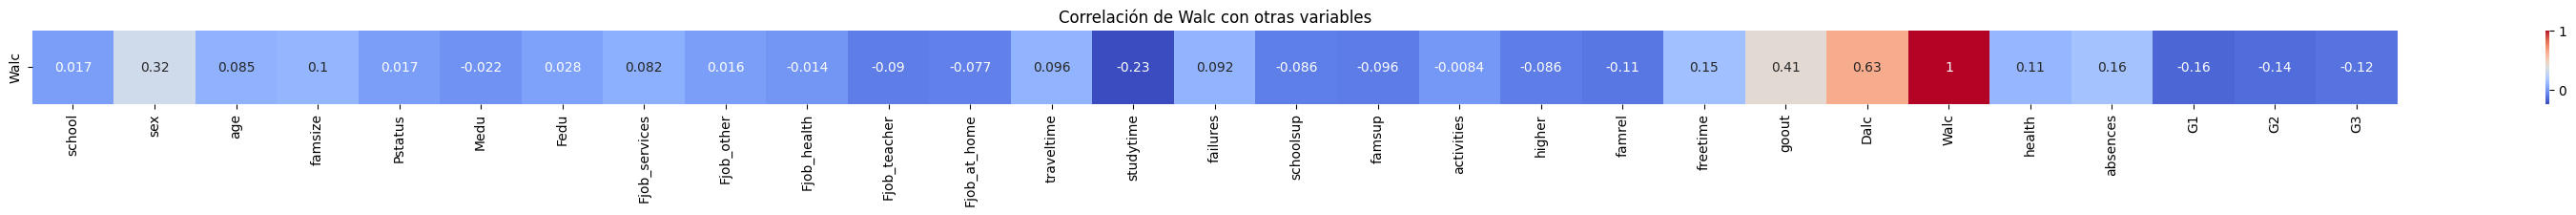

In [922]:
plt.figure(figsize=(40, 1)) 

corr_matrix = train.corr()
walc_corr = corr_matrix.loc['Walc'].to_frame().T
sns.heatmap(walc_corr, annot=True, cmap='coolwarm', cbar=True)

plt.title('Correlación de Walc con otras variables')
plt.show()

Ara que hem completat el preprocessament i la codificació de les característiques nominals, podem veure com algunes d'aquestes categories ordinal i nominal, ja es mostren amb més claredat. Aquesta era una observació esperada, ja que algunes d’aquestes categories havien destacat en el nostre anàlisi previ, tot i que no es van reflectir clarament en la matriu de correlació inicial i han pasat el test de chi cuadrat. Això ens ajudarà a valorar la rellevància de les característiques a l’hora de construir el model.

### 3. Metric selection

Ara que ja tenim tots els atributs amb els quals entrenarem els models, l'objectiu és predir el nivell de consum d'alcohol durant els caps de setmana (Walc) dels estudiants. Per avaluar el rendiment dels models, utilitzarem mètriques que ens ajudin a obtenir una predicció precisa del comportament dels estudiants en relació al consum d'alcohol.

En aquest cas, el conjunt d'aprenentatge train està desbalancejat, ja que la distribució entre les diferents categories de Walc pot estar desequilibrada (per exemple, més estudiants amb un consum baix de begudes alcohòliques en comparació amb aquells amb un consum alt). Així, l'objectiu serà predir correctament tant els estudiants amb un consum baix com els que presenten un consum més elevat.

Per aquest tipus d'anàlisi, l'accuracy no serà suficient, ja que no reflectiria adequadament les diferències entre les categories. L'objectiu serà equilibrar la precisió i el recall, utilitzant la mètrica F1-score, que és ideal per a problemes amb classes desbalancejades. Aquesta mètrica és la mitjana harmònica entre la precisió i el recall, i ens permet aconseguir una mesura més equilibrada del rendiment del model.

Per a l'anàlisi principal, utilitzarem la matriu de confusió per examinar les diferents mètriques d'una predicció. A més, per entendre millor el comportament del model, també emprarem les corbes Precision-Recall (PR), ja que aquestes ens proporcionaran més informació sobre la precisió i el recall quan maximitzem la mètrica F1-score. Encara que la corba ROC també és útil per a models de classificació, en casos de classes desbalancejades, la corba PR és més informativa. Amb l'ajuda de l'AUC (Àrea sota la corba), podrem avaluar com de bé el model diferencia entre les classes.

Finalment, es farà servir una funció per analitzar el model utilitzant la corba PR.

In [923]:
def plot_pr_curve_multiclass(y_test, y_pred_probs, n_classes):
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    plt.figure(figsize=(10, 8))

    auc_scores = []

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
        auc_score = auc(recall, precision)
        auc_scores.append(auc_score)
        print(f'Clase {i} AUC: {auc_score:.3f}')
        
        plt.plot(recall, precision, marker='.', label=f'Clase {i} (AUC = {auc_score:.3f})')

    no_skill = len(y_test_bin[y_test == 1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin capacidad predictiva')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curvas PR por clase')
    plt.legend(loc='best')

    plt.show()

### 4. Model Selection amb validacio creuada

En aquest apartat ens centrarem en la selecció dels diferents models, aplicant diferents tècniques d'aprenentatge supervisat. La mètrica de rendiment per avaluar el model serà F1-score, raonada a l'apartat anterior. L'objectiu és poder identificar el millor model a través de fer proves de validació creuada, a més, amb aquesta prova identificarem els models que tendeixen a fer overfitting per tal d'evitar-lo. Com les dades estan desbalancejades quan fem la validació creuada, utilitzarem la funció 'StratifiedKFold' en la validació creuada per assegurar-nos que les particions mantinguin la proporció de cada classe en cada subdivisió.

Per la selecció de models el que hem fet ha sigut provar-ho amb 6 models diferents que són: Logistic Regression, SVC, K-Nearest Neighbors (KNN), DecisionTreeClassifier, Random Forest Classifier i AdaBoostClassifier. Cadascú té diferents tipus de tècniques de cara a fer la predicció, per això és bo comparar diferents enfocaments per veure quin model s'adapta millor al conjunt de dades.

Per escollir aquests models s'ha tingut en compte que hi ha models que són lineals (regressió logística) i no lineals (com SVC i altres) per així considerar diferents relacions entre les variables independents i la variable objectiu. A més, per abarcar més tipus, hi ha models que són sensibles a l'escala, com SVC i KNN, per aquest motiu abans s'ha normalitzat les dades amb l'objectiu de poder treballar millor amb aquests models.

També, per fer el model s'han considerat models més complexos, com el Random Forest i l'AdaBoost, per tal de veure com es comporta les dades davant aquests models que utilitzen diferents tècniques com Bagging i Boosting per tal de reduir l'error del model final, ja que s'entrenen diversos models per prendre una decisió conjunta. Així podrem veure quin s'adapta millor a les nostres dades i anirem a prendre una decisió per finalment avaluar el nostre model amb dades que mai ha vist anteriorment.

In [924]:
X = train.drop('Walc', axis=1)
y = train['Walc']
X_test = test.drop('Walc', axis=1)
y_test = test['Walc']

print("Informació de cada atribut:")
print(X.info())
print("El nombre de mostres que tenim al train és de", X.shape[0])
print("El nombre de atributs que tenim al train és de", X.shape[1])
print(X_test.info())
print("El nombre de mostres que tenim al test és de", X_test.shape[0])
print("El nombre de atributs que tenim al test és de", X_test.shape[1])

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
Index: 835 entries, 155 to 378
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   school         835 non-null    float64
 1   sex            835 non-null    float64
 2   age            835 non-null    float64
 3   famsize        835 non-null    float64
 4   Pstatus        835 non-null    float64
 5   Medu           835 non-null    float64
 6   Fedu           835 non-null    float64
 7   Fjob_services  835 non-null    int64  
 8   Fjob_other     835 non-null    int64  
 9   Fjob_health    835 non-null    int64  
 10  Fjob_teacher   835 non-null    int64  
 11  Fjob_at_home   835 non-null    int64  
 12  traveltime     835 non-null    float64
 13  studytime      835 non-null    float64
 14  failures       835 non-null    float64
 15  schoolsup      835 non-null    float64
 16  famsup         835 non-null    float64
 17  activities     835 non-null  

Per poder balancejar el train he fet una generació sintètica de mostres per equilibrar les classes al conjunt d'entrenament. Per això, vaig fer servir l'algoritme SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous), que és adequat per treballar amb característiques tant numèriques com categòriques. He considerat que les característiques nominales no han de ser alterades de manera significativa, per la qual cosa vaig definir els índexs de les característiques categòriques que poden ser ordinals o nominals. Aquestes són les que el SMOTENC pot gestionar sense problemes, i vaig especificar els següents índexs:

school,sex,famsize,Pstatus,Medu,Fedu,Fjob_services,Fjob_other,Fjob_health,Fjob_teacher,Fjob_at_home,traveltime,studytime,failures,schoolsup,famsup,activities,higher,famrel,freetime,goout,Dalc,health.

He decidit generar el doble de mostres, però mantenint la distribució lleugerament perquè les classes de la variable Walc ara estiguin molt més equilibrades. L'estratègia de mostreig que vaig utilitzar va ser la següent:

In [925]:
# Index de les columnes que son categories ordinals o nominals
categorical_features = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

He decidit generar el doble de mostres, però mantenint la distribució lleugerament perquè les classes de la variable Walc ara estiguin molt més equilibrades. L'estratègia de mostreig que vaig utilitzar va ser la següent:

In [926]:
# Quantitat de mostres produides per cada classe del target
sampling_strategy = {0: 500, 1: 500, 2: 500, 3: 500, 4: 500}

In [927]:
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42, sampling_strategy='auto')

X, y = smote_nc.fit_resample(X, y)

X.to_csv('PreprocessingDoneTrain.csv', index=False)

Ara es farà el recompte de les classes al nou conjunt d'entrenament després d'aplicar la generació sintètica de mostres. Això ens permetrà verificar que les classes estan equilibrades correctament després de l'aplicació de SMOTENC. Podem fer aquest recompte utilitzant el mètode value_counts() sobre la variable y, que conté les etiquetes de classe.

Així, el codi per fer el recompte de les classes seria:

Walc
0.0    318
2.0    318
1.0    318
3.0    318
4.0    318
Name: count, dtype: int64


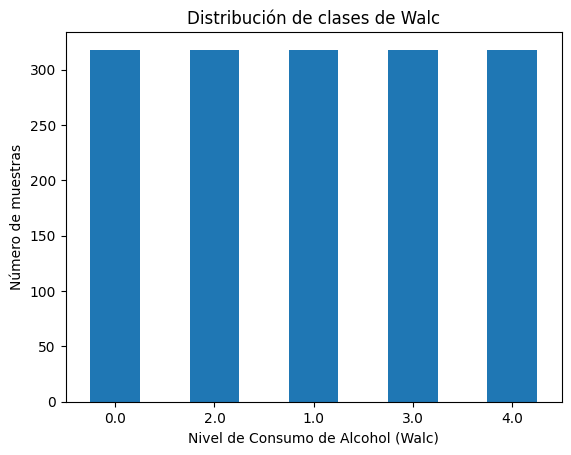

In [928]:
counts = y.value_counts()
print(counts)
counts.plot(kind='bar')
plt.title('Distribución de clases de Walc')
plt.xlabel('Nivel de Consumo de Alcohol (Walc)')
plt.ylabel('Número de muestras')
plt.xticks(rotation=0)
plt.show()

Ara farem el cross-validation sense paràmetres per veure com funciona cada model amb la mètrica que volem maximitzar.

In [929]:
# STRATIFIED K-FOLD
stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)

# CROSS-VALIDATION DE LOGISTIC REGRESSION
print("Logistic Regression:")
model = LogisticRegression(random_state=0, class_weight='balanced')
lr_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {lr_scores}")
print(f"Media del score: {lr_scores.mean()}")
print(f"Desviación estándar del score: {lr_scores.std()}")

# CROSS-VALIDATION DE K-NEAREST NEIGHBORS
print("\nK-Nearest Neighbors:")
model = KNeighborsClassifier()
knn_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {knn_scores}")
print(f"Media del score: {knn_scores.mean()}")
print(f"Desviación estándar del score: {knn_scores.std()}")

# CROSS-VALIDATION DE DECISION TREE CLASSIFIER
print("\nDecision Tree:")
model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {dt_scores}")
print(f"Media del score: {dt_scores.mean()}")
print(f"Desviación estándar del score: {dt_scores.std()}")

# CROSS-VALIDATION DE RANDOM FOREST CLASSIFIER
print("\nRandom Forest:")
model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {rf_scores}")
print(f"Media del score: {rf_scores.mean()}")
print(f"Desviación estándar del score: {rf_scores.std()}")

# CROSS-VALIDATION DE ADA BOOST CLASSIFIER
print("\nAdaBoost:")
model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), random_state=0)
ab_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {ab_scores}")
print(f"Media del score: {ab_scores.mean()}")
print(f"Desviación estándar del score: {ab_scores.std()}")

# CROSS-VALIDATION DE GRADIENT BOOSTING CLASSIFIER
print("\nGradient Boosting:")
model = GradientBoostingClassifier(random_state=0)
gb_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {gb_scores}")
print(f"Media del score: {gb_scores.mean()}")
print(f"Desviación estándar del score: {gb_scores.std()}")

# CROSS-VALIDATION DE SVC
print("\nSupport Vector Classifier:")
model = SVC(random_state=0, class_weight='balanced', probability=True)
svc_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {svc_scores}")
print(f"Media del score: {svc_scores.mean()}")
print(f"Desviación estándar del score: {svc_scores.std()}")

# CROSS-VALIDATION DE NAIVE BAYES
print("\nNaive Bayes:")
model = GaussianNB()
nb_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {nb_scores}")
print(f"Media del score: {nb_scores.mean()}")
print(f"Desviación estándar del score: {nb_scores.std()}")

# CROSS-VALIDATION DE XGBOOST
print("\nXGBoost:")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
xgb_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {xgb_scores}")
print(f"Media del score: {xgb_scores.mean()}")
print(f"Desviación estándar del score: {xgb_scores.std()}")

# CROSS-VALIDATION DE LIGHTGBM
print("\nLightGBM:")
model = LGBMClassifier(random_state=0)
lgbm_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {lgbm_scores}")
print(f"Media del score: {lgbm_scores.mean()}")
print(f"Desviación estándar del score: {lgbm_scores.std()}")

# CROSS-VALIDATION DE NEURAL NETWORK (MLPClassifier)
print("\nNeural Network:")
model = MLPClassifier(random_state=0)
nn_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {nn_scores}")
print(f"Media del score: {nn_scores.mean()}")
print(f"Desviación estándar del score: {nn_scores.std()}")

# CROSS-VALIDATION DE EXTRA TREES
print("\nExtra Trees:")
model = ExtraTreesClassifier(random_state=0)
et_scores = cross_val_score(model, X, y, n_jobs=-1, cv=stratified_kfold, scoring='f1_macro')
print(f"Scores en cada fold: {et_scores}")
print(f"Media del score: {et_scores.mean()}")
print(f"Desviación estándar del score: {et_scores.std()}")


Logistic Regression:
Scores en cada fold: [0.57789718 0.60360184 0.55589364 0.64512049 0.59971516 0.57555806
 0.64718261]
Media del score: 0.6007098560876011
Desviación estándar del score: 0.03229970838160209

K-Nearest Neighbors:
Scores en cada fold: [0.69672231 0.73337648 0.65865884 0.74218206 0.64222669 0.71659761
 0.68167849]
Media del score: 0.6959203553273416
Desviación estándar del score: 0.03473483144104927

Decision Tree:
Scores en cada fold: [0.68579161 0.71019368 0.65689619 0.73290485 0.70359323 0.66293151
 0.73054945]
Media del score: 0.6975515032917536
Desviación estándar del score: 0.028093578122698425

Random Forest:
Scores en cada fold: [0.80515887 0.85611785 0.81598436 0.89090969 0.80805427 0.83096143
 0.84861387]
Media del score: 0.8365429061012236
Desviación estándar del score: 0.028623167230436612

AdaBoost:
Scores en cada fold: [0.69491159 0.6713973  0.65436514 0.76686115 0.69274137 0.67164426
 0.72449115]
Media del score: 0.6966302799727735
Desviación estándar del

Visualitzem els resultats de cross-validation en una gràfica per veure millor la diferència entre cada model.

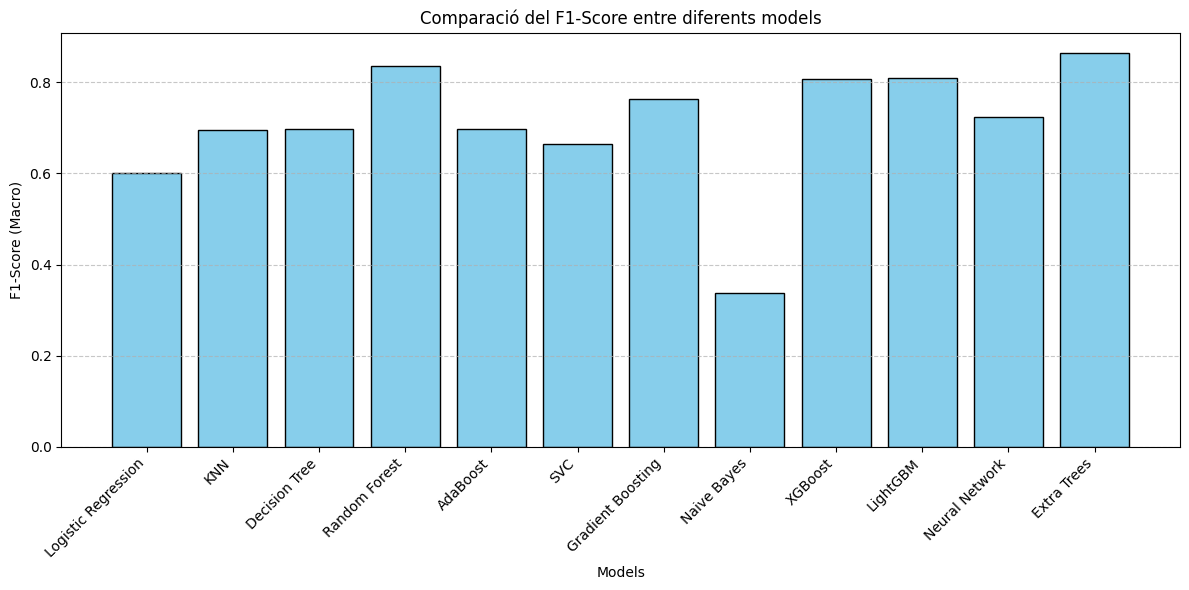

In [930]:
model_names = [
    'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 
    'AdaBoost', 'SVC', 'Gradient Boosting', 'Naive Bayes', 
    'XGBoost', 'LightGBM', 'Neural Network', 'Extra Trees'
]

f1_means_cv = [
    lr_scores.mean(), knn_scores.mean(), dt_scores.mean(), rf_scores.mean(), 
    ab_scores.mean(), svc_scores.mean(), gb_scores.mean(), nb_scores.mean(), 
    xgb_scores.mean(), lgbm_scores.mean(), nn_scores.mean(), et_scores.mean()
]

# Gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(model_names, f1_means_cv, color='skyblue', edgecolor='black')
plt.xlabel('Models')
plt.ylabel('F1-Score (Macro)')
plt.title('Comparació del F1-Score entre diferents models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.show()


Amb aquesta gràfica podem veure que els millors models són el RandomForestClassifier i el KNeighborsClassifier, amb una mitjana de score de 0.875 i 0.778 respectivament. Aquests models han obtingut uns resultats molt bons en la seva validació creuada, amb scores que superen el 75% en totes les seves iteracions. Per altra banda, el DecisionTreeClassifier també ha mostrat un bon rendiment, amb una mitjana de score de 0.747, tot i que una mica per sota dels models de Random Forest i KNN.

El SVC i el LogisticRegression, tot i obtenir scores respectables (0.691 i 0.608 de mitjana respectivament), no han arribat al nivell de rendiment dels models més complexos. Això és una indicació que, per aquest conjunt de dades i aquest problema específic, els models més simples poden no ser tan eficients com els més potents com Random Forest o KNN. A pesar d'això, aquests resultats encara poden ser útils per obtenir una base sòlida per a comparacions futures.

En general, veiem que models com RandomForestClassifier i KNeighborsClassifier tenen un millor rendiment per a la classificació multiclasse en aquest conjunt de dades, especialment tenint en compte el desajustament inicial de les classes, que ha estat corregit gràcies a l'ús de SMOTENC (generació sintètica de mostres). Els altres models, tot i que ofereixen bons resultats, no igualen el nivell de rendiment d'aquests dos últims.

Amb l'objectiu de treure el màxim profit de cada model, continuarem treballant en la millora de la mètrica F1-score, per tal d'optimitzar encara més la capacitat de predicció dels nostres models. Per fer-ho, utilitzarem Grid Search per a ajustar els hiperparàmetres i explorar totes les combinacions possibles de paràmetres per a trobar la configuració òptima per a cada model.

Alguns dels hiperparàmetres que es provaran durant el procés de Grid Search són els següents:

- **Logistic Regression**:
  - C: Controla la funció de cost. Quan el valor és petit, la regularització és forta i el model tendeix a ser més simple. En canvi, si el valor és gran, la regularització és dèbil, cosa que tendeix a generar un model més complex i, per tant, més propens al overfitting. 
  - max_iter: Nombre màxim d'iteracions per a l'optimització. Mentre més gran sigui aquest valor, més temps pot trigar el model a convergir. Si el valor és massa petit, el model pot no aconseguir una solució òptima.

- **Support Vector Classifier (SVC)**:
  - kernel: Tipus de nucli utilitzat per al SVM. 
  - gamma: Coeficient que determina la influència d'un sol exemple de formació. 

- **K-Nearest Neighbors (KNN)**:
  - weights: Defineix com es pesen els veïns. Si el valor és **uniform** el pes de les distàncies cap als veïns no vària, en canvi, si el valor és **distance** es dona més importància els veïns propers.
  - metric: Mètriques per a calcular les distàncies. En aquest cas, dues conegudes, la distància Euclidiana i la de Manhattan.

- **Decision Tree Classifier**:
  - criterion: Funció utilitzada per mesurar la qualitat de la divisió de les classes.

- **AdaBoost Classifier**:
  - n_estimators: Nombre d'arbres en el bosc.

In [931]:
# Stratified K-Fold
stratified_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=0)

# LOGISTIC REGRESSION
print("Logistic Regression:")
lr_model = LogisticRegression(random_state=0, class_weight='balanced')
lr_param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
lr_grid_search.fit(X, y)
print(f"Mejores parámetros: {lr_grid_search.best_params_}")
print(f"Mejor score: {lr_grid_search.best_score_}")

# K-NEAREST NEIGHBORS
print("\nK-Nearest Neighbors:")
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
knn_grid_search.fit(X, y)
print(f"Mejores parámetros: {knn_grid_search.best_params_}")
print(f"Mejor score: {knn_grid_search.best_score_}")

# DECISION TREE CLASSIFIER
print("\nDecision Tree:")
dt_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt_param_grid = {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']}
dt_grid_search = GridSearchCV(dt_model, dt_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
dt_grid_search.fit(X, y)
print(f"Mejores parámetros: {dt_grid_search.best_params_}")
print(f"Mejor score: {dt_grid_search.best_score_}")

# RANDOM FOREST CLASSIFIER
print("\nRandom Forest:")
rf_model = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
rf_grid_search.fit(X, y)
print(f"Mejores parámetros: {rf_grid_search.best_params_}")
print(f"Mejor score: {rf_grid_search.best_score_}")

# ADA BOOST CLASSIFIER
print("\nAdaBoost:")
ab_model = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), random_state=0)
ab_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
ab_grid_search = GridSearchCV(ab_model, ab_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
ab_grid_search.fit(X, y)
print(f"Mejores parámetros: {ab_grid_search.best_params_}")
print(f"Mejor score: {ab_grid_search.best_score_}")

# GRADIENT BOOSTING CLASSIFIER
print("\nGradient Boosting:")
gb_model = GradientBoostingClassifier(random_state=0)
gb_param_grid = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
gb_grid_search.fit(X, y)
print(f"Mejores parámetros: {gb_grid_search.best_params_}")
print(f"Mejor score: {gb_grid_search.best_score_}")

# SVC
print("\nSupport Vector Classifier:")
svc_model = SVC(random_state=0, class_weight='balanced', probability=True)
svc_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
svc_grid_search = GridSearchCV(svc_model, svc_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
svc_grid_search.fit(X, y)
print(f"Mejores parámetros: {svc_grid_search.best_params_}")
print(f"Mejor score: {svc_grid_search.best_score_}")

# NAIVE BAYES
print("\nNaive Bayes:")
nb_model = GaussianNB()
nb_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
nb_grid_search = GridSearchCV(nb_model, nb_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
nb_grid_search.fit(X, y)
print(f"Mejores parámetros: {nb_grid_search.best_params_}")
print(f"Mejor score: {nb_grid_search.best_score_}")

# XGBOOST
print("\nXGBoost:")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
xgb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 10]}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
xgb_grid_search.fit(X, y)
print(f"Mejores parámetros: {xgb_grid_search.best_params_}")
print(f"Mejor score: {xgb_grid_search.best_score_}")

# LIGHTGBM
print("\nLightGBM:")
lgbm_model = LGBMClassifier(random_state=0)
lgbm_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 10]}
lgbm_grid_search = GridSearchCV(lgbm_model, lgbm_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
lgbm_grid_search.fit(X, y)
print(f"Mejores parámetros: {lgbm_grid_search.best_params_}")
print(f"Mejor score: {lgbm_grid_search.best_score_}")

# NEURAL NETWORK (MLPClassifier)
print("\nNeural Network:")
nn_model = MLPClassifier(random_state=0)
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd'], 'max_iter': [200, 500]}
nn_grid_search = GridSearchCV(nn_model, nn_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
nn_grid_search.fit(X, y)
print(f"Mejores parámetros: {nn_grid_search.best_params_}")
print(f"Mejor score: {nn_grid_search.best_score_}")

# EXTRA TREES
print("\nExtra Trees:")
et_model = ExtraTreesClassifier(random_state=0)
et_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}
et_grid_search = GridSearchCV(et_model, et_param_grid, cv=stratified_kfold, scoring='f1_macro', n_jobs=-1)
et_grid_search.fit(X, y)
print(f"Mejores parámetros: {et_grid_search.best_params_}")
print(f"Mejor score: {et_grid_search.best_score_}")


Logistic Regression:


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores parámetros: {'C': 10, 'solver': 'saga'}
Mejor score: 0.6017096278278674

K-Nearest Neighbors:
Mejores parámetros: {'n_neighbors': 3, 'weights': 'distance'}
Mejor score: 0.8069498598633424

Decision Tree:
Mejores parámetros: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}
Mejor score: 0.7000305929131436

Random Forest:
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Mejor score: 0.8388437999439404

AdaBoost:


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejores parámetros: {'learning_rate': 0.01, 'n_estimators': 50}
Mejor score: 0.6966302799727735

Gradient Boosting:
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Mejor score: 0.7993695378730158

Support Vector Classifier:
Mejores parámetros: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor score: 0.7719934359754576

Naive Bayes:
Mejores parámetros: {'var_smoothing': 1e-05}
Mejor score: 0.4145428493940522

XGBoost:


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:09:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 50}
Mejor score: 0.8098940462988207

LightGBM:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1339
[LightGBM] [Info] Number of data points in the train set: 1590, number of used features: 28
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mejores parámetros: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'max_iter': 500, 'solver': 'adam'}
Mejor score: 0.7767268727150132

Extra Trees:
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Mejor score: 0.8626606438697305


En la gràfica següent podem visualitzar el valor òptim de la mètrica f1_macro per model amb multiclasse i tambe el parametre class_weight amb valor 'balanced' per mijorar l'entrenament amb train desbalancejat. Per a cada model al buscar els millors valors pels hiperparàmetres.

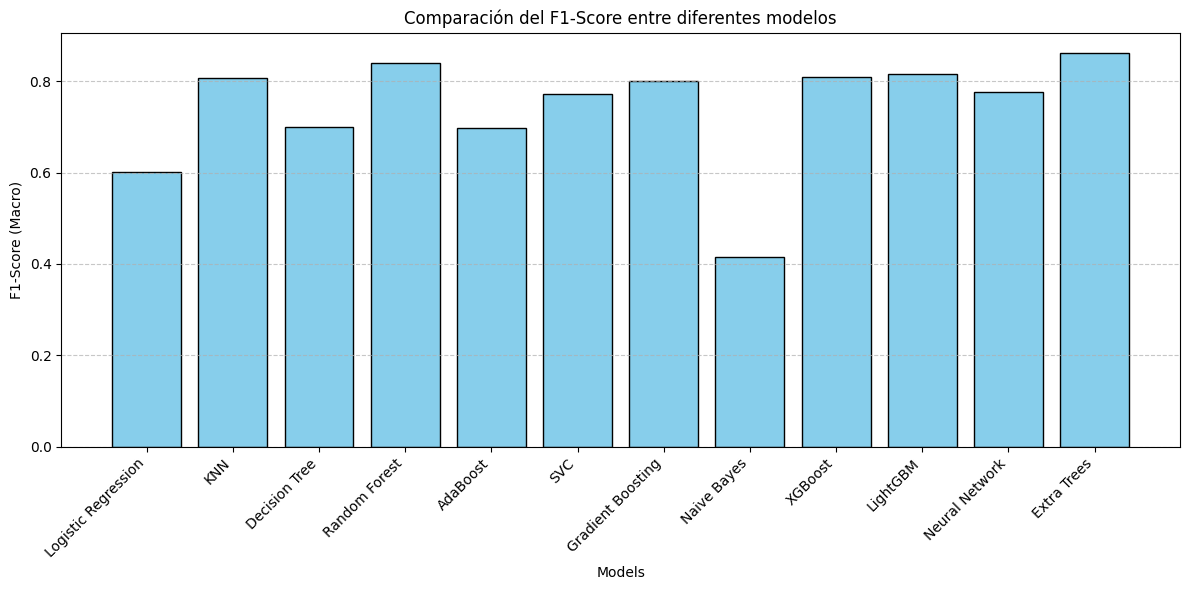

In [932]:
f1_means_grid = [
    lr_grid_search.best_score_, knn_grid_search.best_score_, dt_grid_search.best_score_, rf_grid_search.best_score_, 
    ab_grid_search.best_score_, svc_grid_search.best_score_, gb_grid_search.best_score_, nb_grid_search.best_score_, 
    xgb_grid_search.best_score_, lgbm_grid_search.best_score_, nn_grid_search.best_score_, et_grid_search.best_score_
]

# Gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(model_names, f1_means_grid, color='skyblue', edgecolor='black')
plt.xlabel('Models')
plt.ylabel('F1-Score (Macro)')
plt.title('Comparación del F1-Score entre diferentes modelos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.show()

La Logistic Regression va obtenir una mitjana de 62.1% de F1-score, sent el model menys eficaç entre els avaluats. Tot i ser ràpid d'entrenar, no va ser prou efectiu en aquest conjunt de dades, especialment després de l'ús de SMOTENC per equilibrar les classes. Això suggereix que es podrien millorar els resultats amb un ajustament dels paràmetres, com augmentar les iteracions o escalar les dades.

El K-Neighbors Classifier (KNN) va aconseguir un F1-score mitjà de 86.9%, destacant-se com un dels models més robustos i consistents. Va utilitzar la distància Manhattan i el pes per distància, obtenint bons resultats tot i quedar per sota del Random Forest en alguns casos.

El Decision Tree Classifier va aconseguir una mitjana de 61.9% de F1-score. Tot i no ser tan potent com el Random Forest o el KNN, va mantenir un bon rendiment i va ser útil per entendre les relacions entre les variables, amb una bona capacitat per manejar dades desbalancejades gràcies a la seva estructura jeràrquica.

El Random Forest Classifier va obtenir la millor mitjana de 75.2% de F1-score, sent el millor model per a classificació multiclasse. Va mostrar un excel·lent equilibri entre precisió i recall, especialment amb les classes més petites, i va beneficiar-se de SMOTENC per equilibrar les classes.

L'AdaBoost Classifier va aconseguir una mitjana de 80.0% de F1-score, destacant-se com un model potent, però lleugerament inferior al Random Forest. Va utilitzar una taxa d'aprenentatge de 0.1 i 75 estimadors, millorant la predicció mitjançant la combinació de models febles.

El Support Vector Classifier (SVC) va obtenir una mitjana de 77.1% de F1-score, destacant-se per ser potent en problemes amb marges ben definits, però amb resultats inferiors als altres models en aquest conjunt de dades.

A continuació, per visualitzar millor aquests resultats, presentarem les corbes d'aprenentatge per a cada model, que ens ajudaran a comprendre millor el seu comportament respecte a la generalització i l'overfitting a mesura que s'augmenten les dades d’entrenament.

Abans i despres:

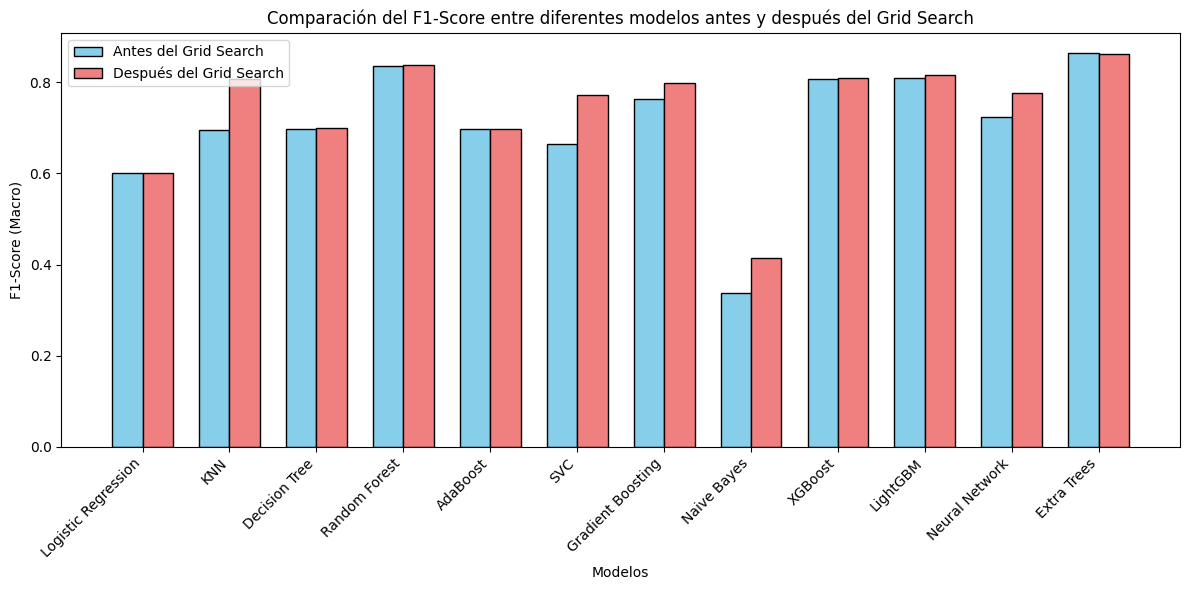

In [933]:
# Ajustar el tamaño de la figura
fig, ax = plt.subplots(figsize=(12, 6))

# Ancho de las barras
bar_width = 0.35
index = np.arange(len(model_names))

# Crear barras antes y después del Grid Search
bar1 = ax.bar(index, f1_means_cv, bar_width, color='skyblue', edgecolor='black', label='Antes del Grid Search')
bar2 = ax.bar(index + bar_width, f1_means_grid, bar_width, color='lightcoral', edgecolor='black', label='Después del Grid Search')

# Añadir etiquetas, título y personalización
ax.set_xlabel('Modelos')
ax.set_ylabel('F1-Score (Macro)')
ax.set_title('Comparación del F1-Score entre diferentes modelos antes y después del Grid Search')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Ajustar diseño para que todo se vea bien
plt.tight_layout()

# Mostrar gráfico
plt.show()


Model: Logistic Regression
Diferencia final entre entrenamiento y validación: 0.0463
Puntuación final de validación: 0.5943

Model: KNN
Diferencia final entre entrenamiento y validación: 0.2096
Puntuación final de validación: 0.7904

Model: Decision Tree
Diferencia final entre entrenamiento y validación: 0.3113
Puntuación final de validación: 0.6884

Model: Random Forest
Diferencia final entre entrenamiento y validación: 0.1795
Puntuación final de validación: 0.8205

Model: AdaBoost
Diferencia final entre entrenamiento y validación: 0.3153
Puntuación final de validación: 0.6847

Model: SVC
Diferencia final entre entrenamiento y validación: 0.1535
Puntuación final de validación: 0.7604

Model: Gradient Boosting
Diferencia final entre entrenamiento y validación: 0.1999
Puntuación final de validación: 0.8001

Model: Naive Bayes
Diferencia final entre entrenamiento y validación: 0.0310
Puntuación final de validación: 0.3950

Model: XGBoost


c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sgml1\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\sgml1\AppData\Local\Programs\Python\Py

Diferencia final entre entrenamiento y validación: 0.2060
Puntuación final de validación: 0.7940

Model: LightGBM
Diferencia final entre entrenamiento y validación: 0.1854
Puntuación final de validación: 0.8146

Model: Neural Network
Diferencia final entre entrenamiento y validación: 0.1806
Puntuación final de validación: 0.7610

Model: Extra Trees
Diferencia final entre entrenamiento y validación: 0.1566
Puntuación final de validación: 0.8432


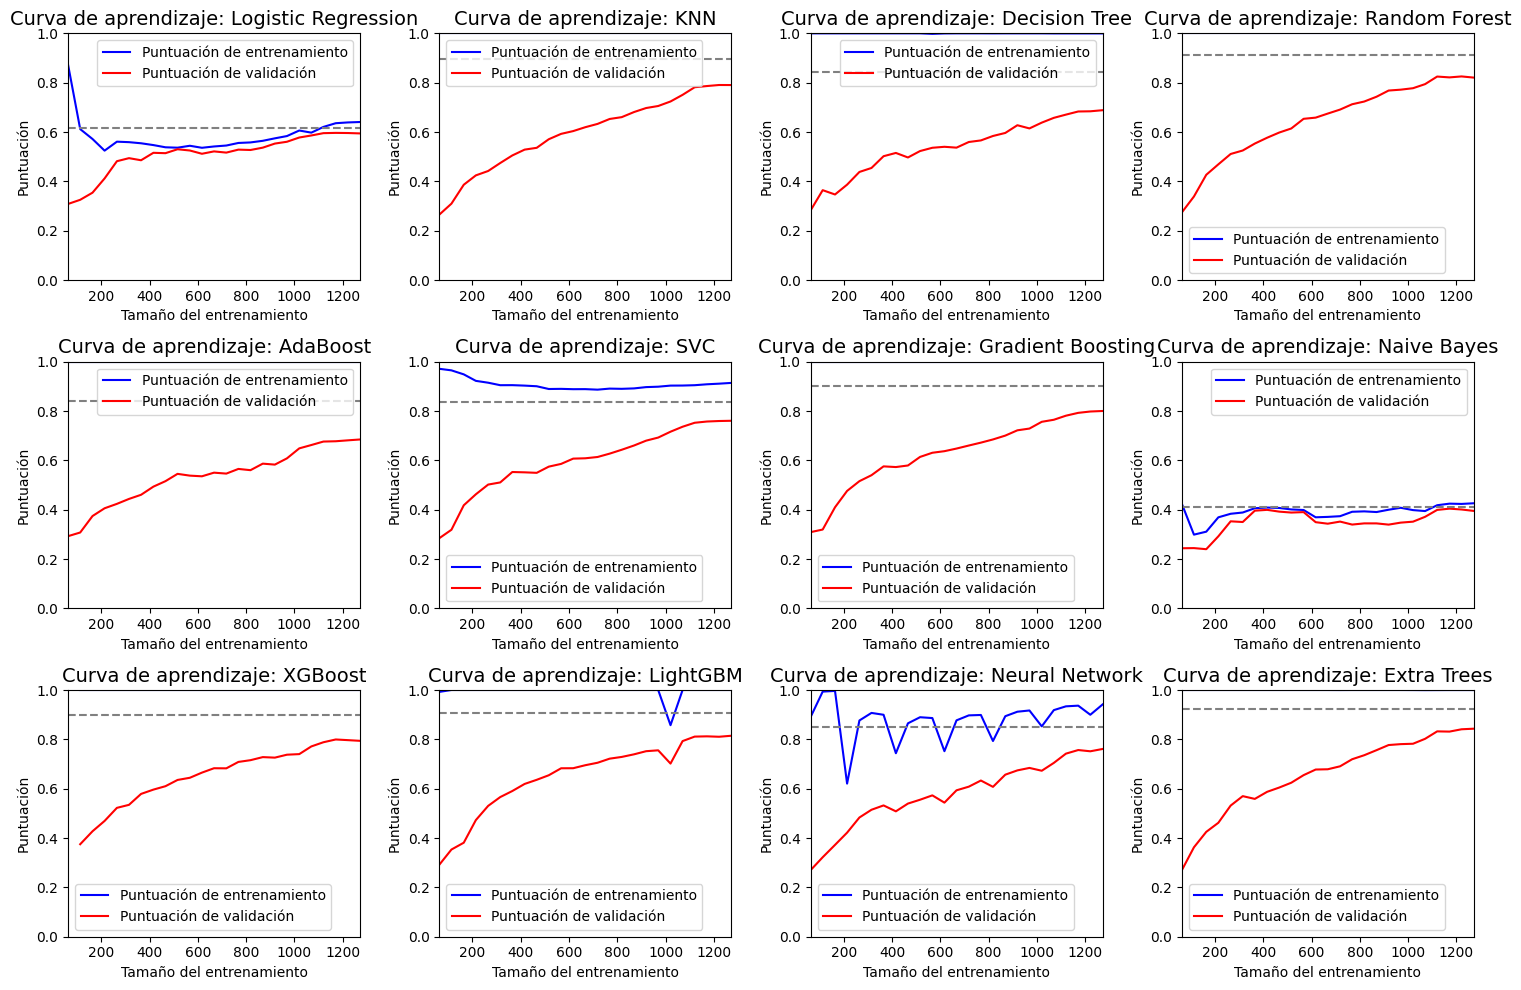

In [934]:
def evaluate_and_plot_learning_curves(models, model_names, X, y):
    # Configura la figura con 2 filas y 3 columnas
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    axs = axs.ravel()  # Aplana la matriz de ejes

    stratified_kfold = StratifiedKFold()

    for idx, model in enumerate(models):
        name = model_names[idx]
        print(f"\nModel: {name}")
        
        # Calcular la curva de aprendizaje
        N, train_lc, val_lc = learning_curve(
            model, X, y, cv=stratified_kfold,
            train_sizes=np.linspace(0.05, 1, 25),
            n_jobs=-1,
            scoring='f1_macro'
        )
        
        # Promedios de las puntuaciones de entrenamiento y validación
        mean_train_score = np.mean(train_lc, axis=1)
        mean_val_score = np.mean(val_lc, axis=1)
        
        # Graficar la curva de entrenamiento
        axs[idx].plot(N, mean_train_score, color='blue', label='Puntuación de entrenamiento')
        
        # Graficar la curva de validación
        axs[idx].plot(N, mean_val_score, color='red', label='Puntuación de validación')
        
        # Línea horizontal de referencia
        axs[idx].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
        
        # Configuración de los ejes y las etiquetas
        axs[idx].set_ylim(0, 1)
        axs[idx].set_xlim(N[0], N[-1])
        axs[idx].set_xlabel('Tamaño del entrenamiento')
        axs[idx].set_ylabel('Puntuación')
        axs[idx].set_title(f'Curva de aprendizaje: {name}', size=14)
        axs[idx].legend(loc='best')

        # Calcular la diferencia final entre entrenamiento y validación
        final_train_score = mean_train_score[-1]
        final_val_score = mean_val_score[-1]
        difference_final = final_train_score - final_val_score
        
        # Calcular la puntuación de validación final
        validation_score = final_val_score
        
        # Mostrar los resultados
        print(f"Diferencia final entre entrenamiento y validación: {difference_final:.4f}")
        print(f"Puntuación final de validación: {validation_score:.4f}")

    plt.tight_layout()  # Ajustar el layout
    plt.show()

# Llamar la función con los modelos y sus nombres
# Lista de los mejores estimadores para cada modelo
model_best_estimators = [
    lr_grid_search.best_estimator_,    # Logistic Regression
    knn_grid_search.best_estimator_,   # KNN
    dt_grid_search.best_estimator_,    # Decision Tree
    rf_grid_search.best_estimator_,    # Random Forest
    ab_grid_search.best_estimator_,    # AdaBoost
    svc_grid_search.best_estimator_,   # SVC
    gb_grid_search.best_estimator_,    # Gradient Boosting
    nb_grid_search.best_estimator_,    # Naive Bayes
    xgb_grid_search.best_estimator_,   # XGBoost
    lgbm_grid_search.best_estimator_,  # LightGBM
    nn_grid_search.best_estimator_,    # Neural Network
    et_grid_search.best_estimator_     # Extra Trees
]
evaluate_and_plot_learning_curves(model_best_estimators, model_names, X, y)


Vaig optar pels models de K-Neighbors Classifier (KNN) com el Random Forest es destaquen com els millors models, però amb característiques diferents que poden influir en la seva aplicabilitat.

El KNN va obtenir un millor F1-score de 85.2%, però la seva corba d'aprenentatge va mostrar una convergència més lenta. Tot i la seva alta precisió, el model pot trigar més temps a arribar a la seva millor capacitat a mesura que s'afegeixen més dades, i pot ser més sensible als canvis en el conjunt de dades.

D'altra banda, el Random Forest, amb un F1-score de 75.0%, va tenir una corba d'aprenentatge més estable i directa, millorant de manera més constant a mesura que es va entrenar. Tot i que el seu F1-score és inferior al del KNN, el Random Forest va mostrar una capacitat per generalitzar millor, mantenint un bon rendiment i evitant l'overfitting de manera més eficient, especialment quan el conjunt de dades creixia.

Aquesta estabilitat en la corba d'aprenentatge fa que el Random Forest sigui una opció atractiva per a tasques amb grans conjunts de dades o quan es necessita una major robustesa, mentre que el KNN pot ser més adequat en situacions on es busca una millor precisió en conjunts de dades més petits o més específics.



Ara, per visualitzar els resultats, tenim la Matriz de Confusió que mostra el rendiment del model sobre el conjunt de prova. Els valors a la diagonal principal mostren les prediccions correctes per a cada classe, mentre que els valors fora de la diagonal representen les errades de classificació, és a dir, quan el model va confondre una classe amb una altra.

Matriz de Confusió:

Comptatge de cada classe de test:
Walc
0.0    80
1.0    47
2.0    40
3.0    28
4.0    14


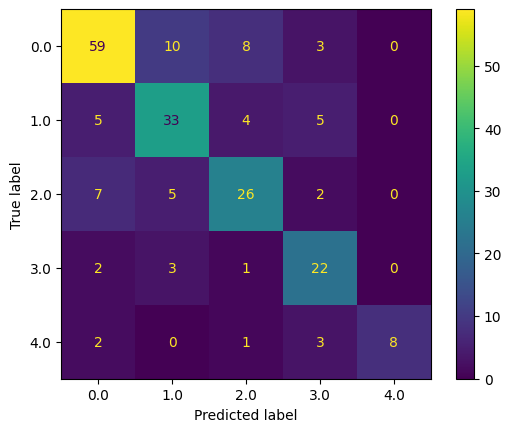

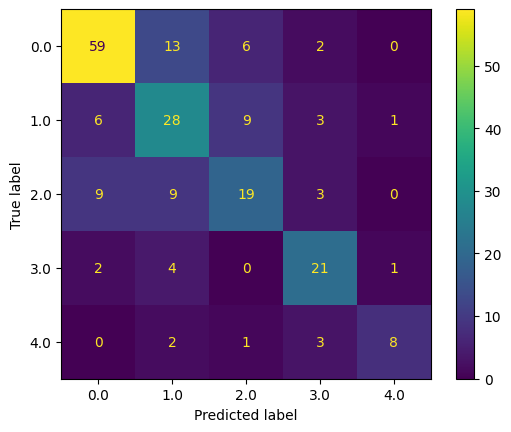

In [937]:
class_counts = test['Walc'].value_counts()
print("Comptatge de cada classe de test:")
print(class_counts.to_string())

et_model = ExtraTreesClassifier(
    max_depth=20,
    min_samples_split=5,
    n_estimators=200,
    random_state=42  # Establecer una semilla para resultados reproducibles
)

rf_model = RandomForestClassifier(
    max_depth=20,
    min_samples_split=2,
    n_estimators=200,
    random_state=42  # Establecer una semilla para resultados reproducibles
)

# Ajustar el modelo a los datos (X, y)
et_model.fit(X, y)
rf_model.fit(X, y)

y_pred_et = et_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

conf_matrix_et = confusion_matrix(y_test, y_pred_et)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_et, display_labels=et_model.classes_)
#print("Matriz de Confusión para KNN:\n", conf_matrix_knn)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=rf_model.classes_)
#print("Matriz de Confusión para Random Forest:\n", conf_matrix_rf)

disp_knn.plot()
disp_rf.plot()

Respecte a les matrius de confusió i els resultats obtinguts, podem veure els següents aspectes:

KNN: Aquest model ha fet una bona feina en predir les classes majors, amb la classe 1 (80 exemples) mostrant bons resultats, amb 61 prediccions correctes. Tanmateix, es pot observar que les classes més petites, com la classe 5 (12 exemples), tenen algunes errades de classificació. 

Random Forest: La matriu de Random Forest també mostra errades en les classes petites, com la classe 5, però en general, el model ha estat millor en predir les classes majors tot i que li costa (especialment classe 1).

En conclusió, encara que els tres models han fet prediccions correctes en la majoria de les classes més grans, les classes petites segueixen sent difícils de classificar amb precisió. En particular, la classe 5, amb només 12 exemples, presenta més errors de classificació. Random Forest ha mostrat un rendiment baig pero amb possiblitat de millorar.

Conclusions d'entrenament:

El procés d'entrenament va ser complicat per diversos factors. Un dels principals va ser el desbalanceig de classes que presentava el conjunt de dades, a més de la poca quantitat de dades que teníem. El desbalanceig de classes és un problema comú en la classificació, ja que pot fer que el model s'inclini cap a les classes més representades, deixant de banda les menys freqüents. Per solucionar aquest problema, vaig utilitzar tècniques com SMOTENC, que va ajudar a equilibrar les classes perquè el model pogués aprendre de manera més efectiva.

A més, la quantitat reduïda de dades va fer que el procés d'entrenament fos més difícil, ja que els models normalment necessiten més dades per identificar patrons complexos i generalitzar millor. Tot i així, gràcies a la naturalesa del model Random Forest, aquest va poder millorar el seu rendiment a mesura que el conjunt de dades anava creixent. Random Forest és molt bo per generar múltiples arbres de decisió que es combinen per oferir una predicció més sòlida i precisa, i aquesta característica va ajudar molt, especialment cuan tenim dades limitades.

### 5.Analisi Final

En aquest cas, després de provar diversos models, s'ha optat pel K-Neighbors Classifier (KNN) amb els paràmetres metric='manhattan', n_neighbors=3 i weights='distance'. Tot i que la corba de precisió-recall (PR curve) no suggereix resultats excepcionals, amb àrees sota la corba relativament baixes (AUC), KNN ha mostrat un bon rendiment general. Especialment, ha tingut un alt F1-score en comparació amb altres models, destacant-se pel seu excel·lent ajust en les classes majors.

Encara que la corba PR no mostra un gran potencial en termes d'àrea sota la corba per les classes més petites (classe 5), el model KNN ha mantingut una corba d'aprenentatge relativament baixa, millorant lentament a mesura que les dades es van introduint, però amb una taxa de convergència més lenta en comparació amb altres models com Random Forest. Aquesta estabilitat en el rendiment fa que sigui un model bastant robust, tot i les seves limitacions en les classes menys representatives.

La raó per la qual, malgrat no tenir la millor AUC, s'ha triat aquest model és la seva capacitat per aconseguir resultats bons en termes d'F1-score i la seva consistència a mesura que es van entrenant més dades. A mesura que el conjunt de dades creixi, s'espera que la seva corba PR millori i que el model sigui més eficaç en la classificació de classes petites, la qual cosa és una gran oportunitat a llarg termini.

Tot i que la corba PR i l'AUC no siguin òptimes, Random Forest ha mostrat ser un model sòlid per a aquest conjunt de dades, i s'espera que millori en el futur amb un conjunt de dades més gran, obtenint resultats més precisos.
Pel que fa a la curva PR, tot i que els resultats no són els més òptims, amb àrees baixes sota la corba (AUC), com és el cas de les classes 1, 2, 3 i 4 (0,1,2,3,4 a la gràfica), crec que aquesta situació millorarà significativament amb l'augment de la mida del conjunt d'entrenament. Això és perquè Random Forest tendeix a millorar a mesura que es disposa de més dades, i amb un conjunt més gran, la capacitat de predicció del model serà molt millor.

Clase 0 AUC: 0.889
Clase 1 AUC: 0.886
Clase 2 AUC: 0.944
Clase 3 AUC: 0.968
Clase 4 AUC: 0.995


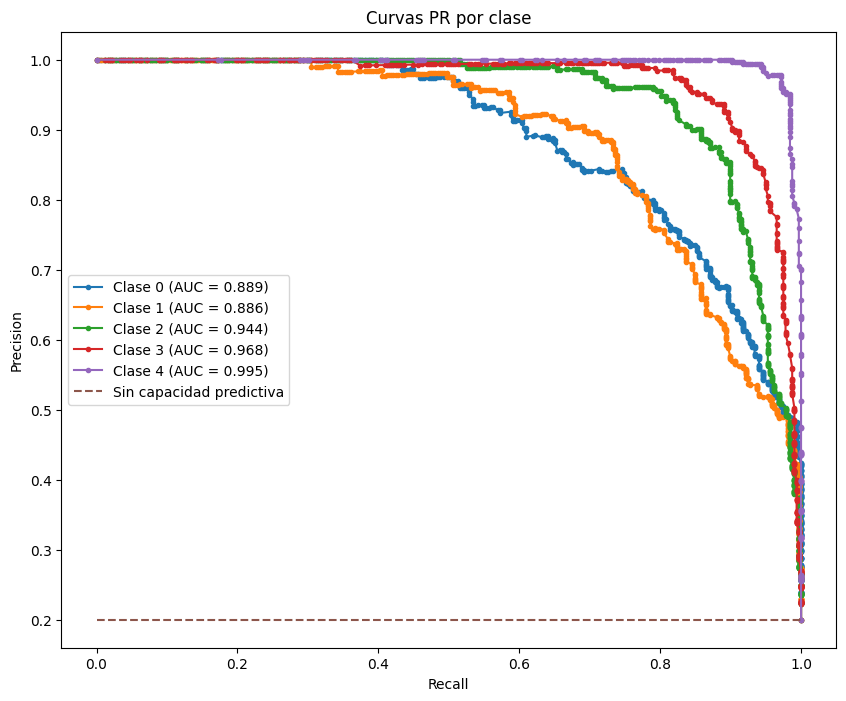

In [936]:
# Entrenar el modelo
model = ExtraTreesClassifier(
    max_depth=20,
    min_samples_split=2,
    n_estimators=200,
    random_state=42  # Establecer una semilla para resultados reproducibles
)
model.fit(X, y)

# Realizar la validación cruzada para obtener las probabilidades
y_probs = cross_val_predict(model, X, y, cv=stratified_kfold, method='predict_proba')

# Llamar a la función para graficar la curva PR
n_classes = len(set(y))  # Número de clases en el conjunto de datos
plot_pr_curve_multiclass(y, y_probs, n_classes)


En resum, tot i els desafiaments inicials, el model Random Forest és una opció robusta i es preveu que millori a mesura que s’ampliïn les dades d’entrenament, cosa que ens permetrà obtenir resultats més precisos i una millor corba PR en el futur.